## [75.06 / 95.58] Organización de Datos
## Trabajo Práctico 1: Análisis Exploratorio de Datos
### Grupo 18: DATAVID-20

* 102732 - Bilbao, Manuel
* 101933 - Karagoz, Filyan
* 98684 - Markarian, Darío
* 100901 - Stroia, Lautaro

## Importación general de librerias y set-up de datos.

In [80]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import re as re

#para instalar WordCloud (para visualizaciones de nube de palabras)
#! pip3 install wordcloud
from wordcloud import WordCloud, STOPWORDS

#Para instalar libreria Emoji
#! pip3 install emoji
import emoji

#Para instalar libreria Geotext
#! pip3 install https://github.com/elyase/geotext/archive/master.zip
import geotext

#Para instalar NLTK
#! pip3 install nltk
import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import word_tokenize

#Para instalar Geopandas
#! pip3 install geopandas
import geopandas as gpd

#! pip3 install descartes

from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.colors as colors

import warnings
warnings.filterwarnings('ignore')

pd.options.display.max_rows = None #mostrar todas las filas del df
%matplotlib inline
plt.style.use('default') # haciendo los graficos un poco mas bonitos en matplotlib
plt.rcParams['figure.figsize'] = (20, 10)
sns.set(style="whitegrid") # seteando tipo de grid en seaborn
pd.options.display.float_format = '{:20,.2f}'.format # suprimimos la notacion cientifica en los outputs

dataframe = pd.read_csv('train.csv')
dataframe.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


## Información general del set de datos

#### Cantidad de filas y columnas; uso de memoria

In [81]:
print("Filas y columnas del set de datos: {}.".format(dataframe.shape))
print("Uso de memoria del set de datos : {:.2f} MB.".format(dataframe.memory_usage().sum() / 1024**2))

Filas y columnas del set de datos: (7613, 5).
Uso de memoria del set de datos : 0.29 MB.


#### Tipos de datos presentes en el dataset

In [82]:
dataframe.dtypes

id           int64
keyword     object
location    object
text        object
target       int64
dtype: object

#### Cantidad de valores nulos/NaN en las columnas del dataset

In [83]:
pd.DataFrame(pd.isna(dataframe).sum(), columns = ['NaN amount'])

,NaN amount
id,0
keyword,61
location,2533
text,0
target,0


#### Cantidad de valores no-repetidos en las columnas del dataset

In [84]:
pd.DataFrame(dataframe.nunique(), columns = ['Non Repeated amount'])

,Non Repeated amount
id,7613
keyword,221
location,3341
text,7503
target,2


## Análisis de la columna *text*

#### Empezamos agregando al dataframe, una columna que indique la longitud de cada tweet.

In [85]:
dataframe['tweet lenght'] = dataframe['text'].str.len()
dataframe.head()

,id,keyword,location,text,target,tweet lenght
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,69
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,38
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,133
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,65
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,88


#### Busco la longitud del tweet más largo y del más corto.

In [86]:
print("La longitud del tweet más largo es: {}".format(dataframe['tweet lenght'].max()))
print("La longitud del tweet más corto es: {}".format(dataframe['tweet lenght'].min()))

La longitud del tweet más largo es: 157
La longitud del tweet más corto es: 7


#### Buscamos en qué rango de longitudes entra cada tweet, para luego poder hacer una visualizacion del tipo cantidad de tweets vs longitud de tweets.

In [87]:
df_len_interval = pd.cut(dataframe['tweet lenght'],[i for i in range(0, dataframe['tweet lenght'].max(), 10)])
df_len_interval.to_frame().head()

,tweet lenght
0,"(60, 70]"
1,"(30, 40]"
2,"(130, 140]"
3,"(60, 70]"
4,"(80, 90]"


#### Visualización que muestra la cantidad de tweets vs longitud de tweets.

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14],
 <a list of 15 Text major ticklabel objects>)

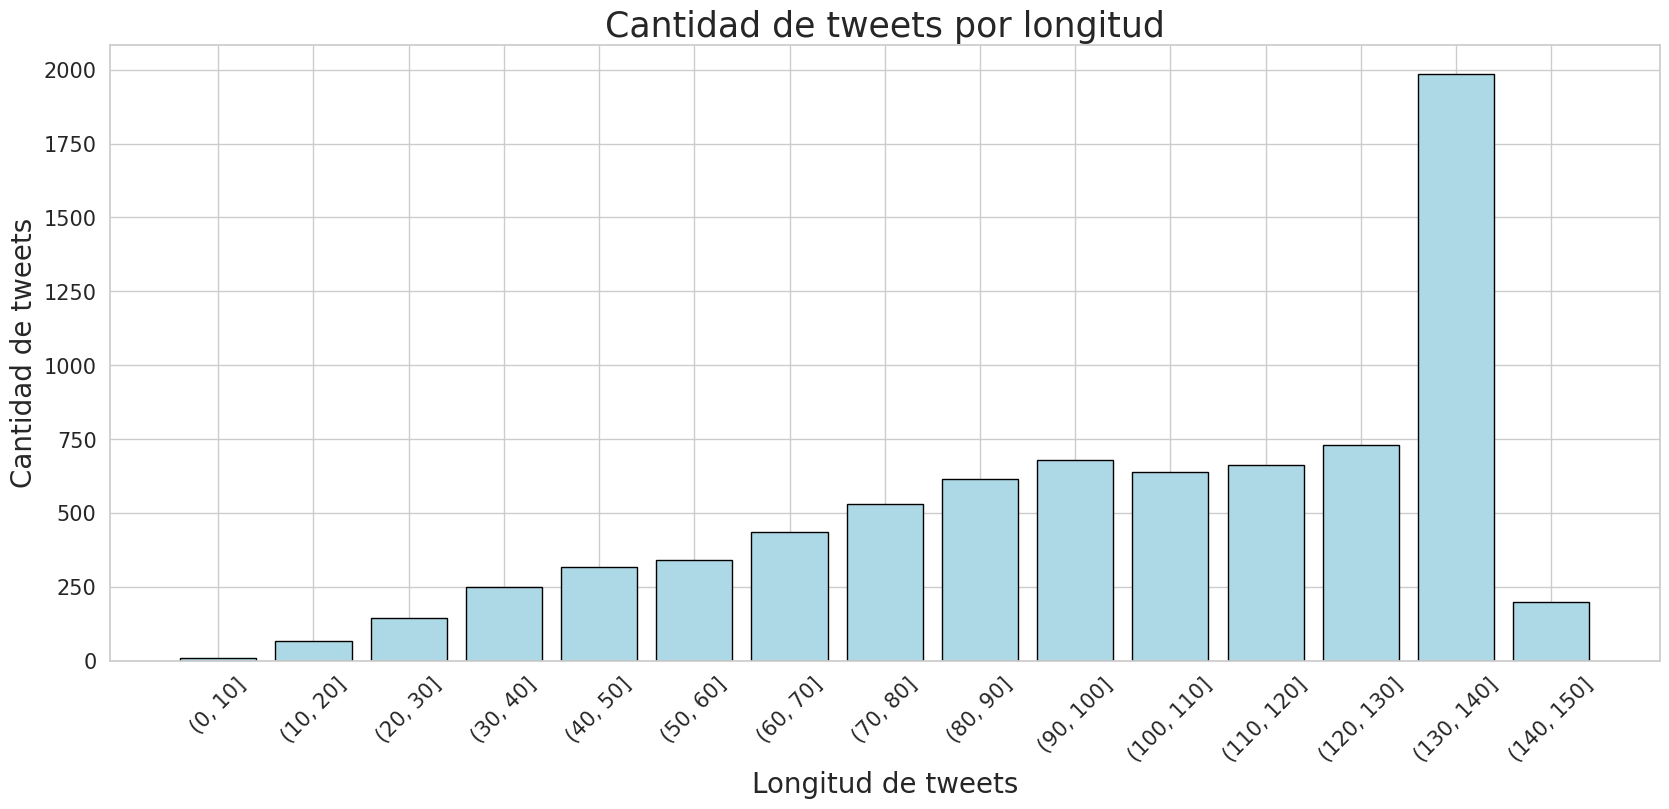

In [88]:
df_lenght = dataframe.groupby(df_len_interval).size()
fig = plt.figure(figsize = (20, 8))
plt.bar(df_lenght.index.astype(str), df_lenght.values, color = 'lightblue',edgecolor = 'black')
plt.xlabel("Longitud de tweets", fontsize=20)
plt.ylabel("Cantidad de tweets",fontsize=20)
plt.title("Cantidad de tweets por longitud", fontsize=25)
plt.tick_params(axis='both', labelsize = 15)
plt.xticks(rotation = 45)

#### Como vemos, la gran mayoria de los tweets tiene una longitud comprendida entre los 130 y los 140 caracteres.

#### Ahora vamos a analizar cuántos tweets poseen Emojis. Para ello, hacemos uso de la libreria emoji. Agregaremos una columna nueva a una copia del dataframe, que indique si ese tweet posee o no emojis.

In [89]:
def text_has_emoji(text):
    for character in text:
        if character in emoji.UNICODE_EMOJI:
            return True
    return False

tweets_emoji_df = dataframe.copy()
tweets_emoji_df = tweets_emoji_df.drop(['keyword','location'],axis=1)
tweets_emoji_df['has_emoji'] = tweets_emoji_df['text'].apply(lambda x: text_has_emoji(x))
tweets_emoji_df['has_emoji'].value_counts()

False    7603
True       10
Name: has_emoji, dtype: int64

#### Como vemos, solo 10 de 7613 tweets poseen emojis, por lo que realizar un análisis mas exhaustivo sería en vano y una perdida de tiempo

#### Procedemos a analizar cuantos tweets poseen menciones hacia otros usuarios (@)

In [90]:
mencion_reg = re.compile(r'(^|\W)@([A-Za-z0-9_]+)(?![A-Za-z0-9_]*\\.)')

def buscar_menciones(x):
    coincidencias = re.findall(mencion_reg, x)
    menciones = ""
    for coincidencia in coincidencias:
        menciones += ", {}".format(coincidencia[1].lower())
    return menciones[2:]

df_menciones = dataframe.copy()
df_menciones = df_menciones.loc[df_menciones['text'].str.contains(mencion_reg)]
df_menciones['mentions'] = df_menciones['text'].map(lambda x: buscar_menciones(x))
df_menciones['mentions amount'] = df_menciones['mentions'].map(lambda x: x.count(',')+1)

print("Cantidad de tweets con menciones: {}".format(len(df_menciones)))
print("Cantidad de menciones en total: {}".format(df_menciones['mentions amount'].sum()))

Cantidad de tweets con menciones: 1994
Cantidad de menciones en total: 2687


#### Mismo análisis anterior pero esta vez enfocandonos en los hashtags (#)

In [91]:
hashtag_reg = re.compile(r'#\w+')

def buscar_hashtags(x):
    coincidencias = re.findall(hashtag_reg, x)
    hashtags = ""
    for coincidencia in coincidencias:
        hashtags += ", {}".format(coincidencia.lower())
    return hashtags[2:]

df_hashtags = dataframe.copy()
df_hashtags = df_hashtags.loc[df_hashtags['text'].str.contains(hashtag_reg)]
df_hashtags['hashtags'] = df_hashtags['text'].map(lambda x: buscar_hashtags(x))
df_hashtags['hashtags amount'] = df_hashtags['hashtags'].map(lambda x: x.count(',')+1)

print("Cantidad de tweets con hashtags: {}".format(len(df_hashtags)))
print("Cantidad de hashtags en total: {}".format(df_hashtags['hashtags amount'].sum()))

Cantidad de tweets con hashtags: 1743
Cantidad de hashtags en total: 3330


#### TOP-10 Hashtags más usados

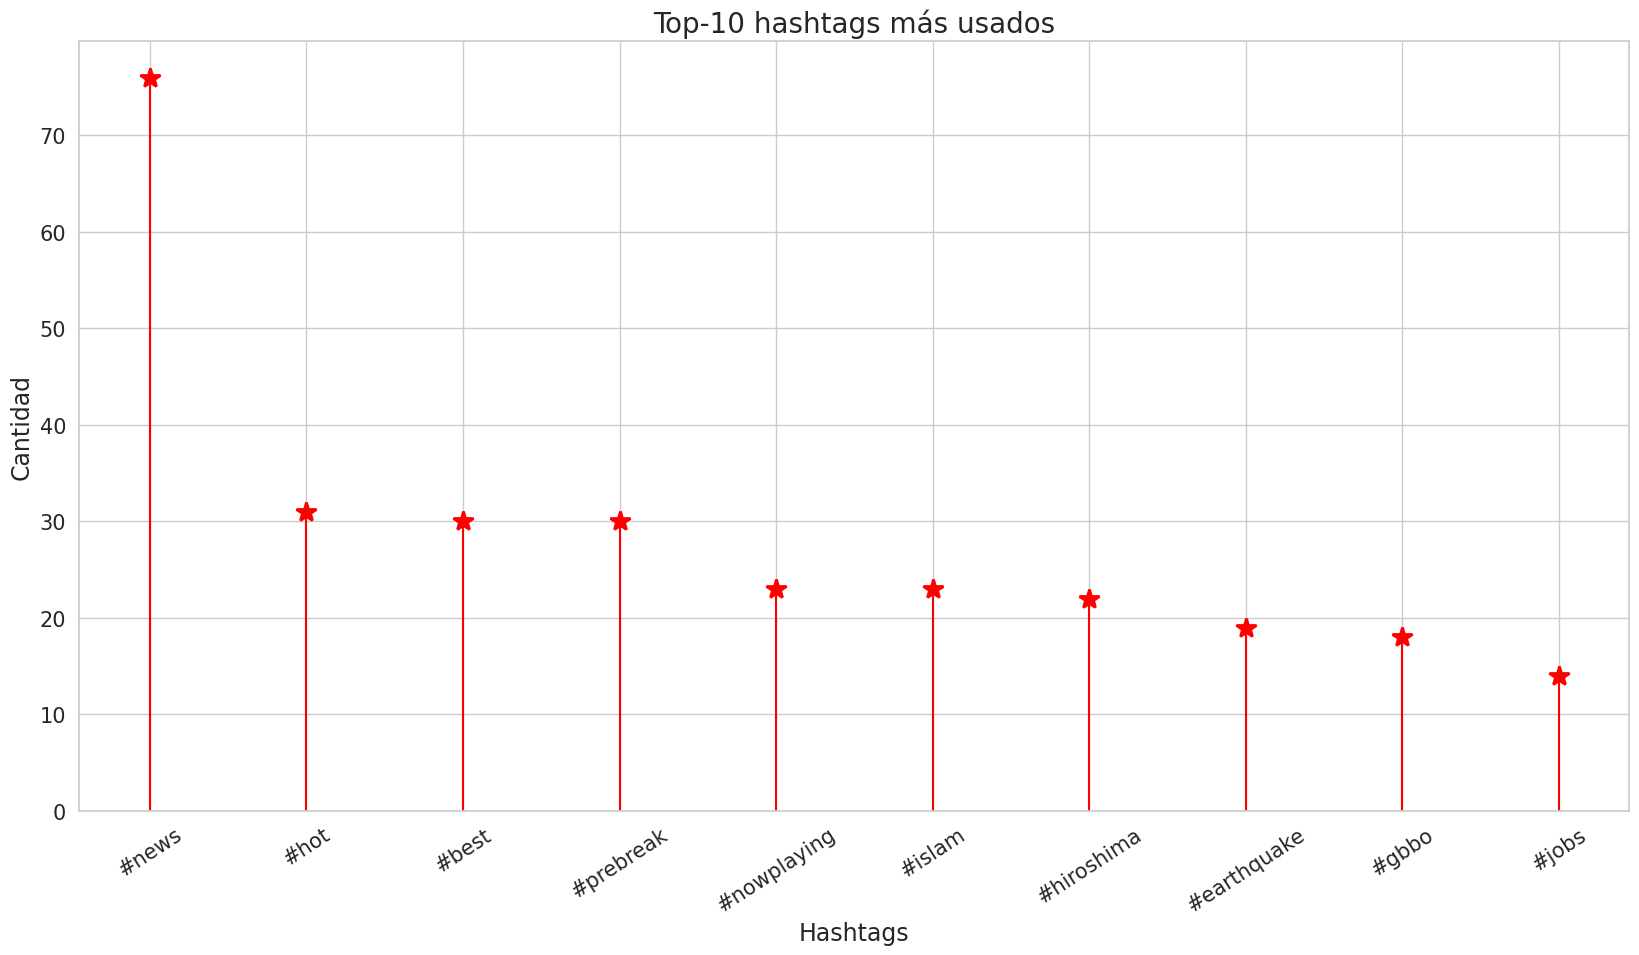

In [92]:
hashtags = {}
for row in df_hashtags['hashtags']:
    for hashtag in row.split(', '):
        if hashtag in hashtags:
            hashtags[hashtag] += 1
        else:
            hashtags[hashtag] = 1
            
MyDF = pd.DataFrame([v for v in hashtags.values()], columns = ['total'], index = [k for k in hashtags.keys()])\
.sort_values('total', ascending=False)

(markerline, stemlines, baseline) = plt.stem(MyDF.head(10).index, MyDF.head(10).total)
plt.setp(markerline, marker='*', markersize=15, markeredgewidth=2, color='red')
plt.setp(stemlines, color='red')
plt.setp(baseline, visible=False)
plt.title("Top-10 hashtags más usados", fontsize = 20)
plt.tick_params(axis = 'both', labelsize=15)
plt.xlabel('Hashtags', fontsize = 17)
plt.ylabel('Cantidad', fontsize = 17)
plt.ylim(bottom=0)
plt.xticks(rotation = 33)

plt.show()

#### TOP-10 Menciones más frecuentes

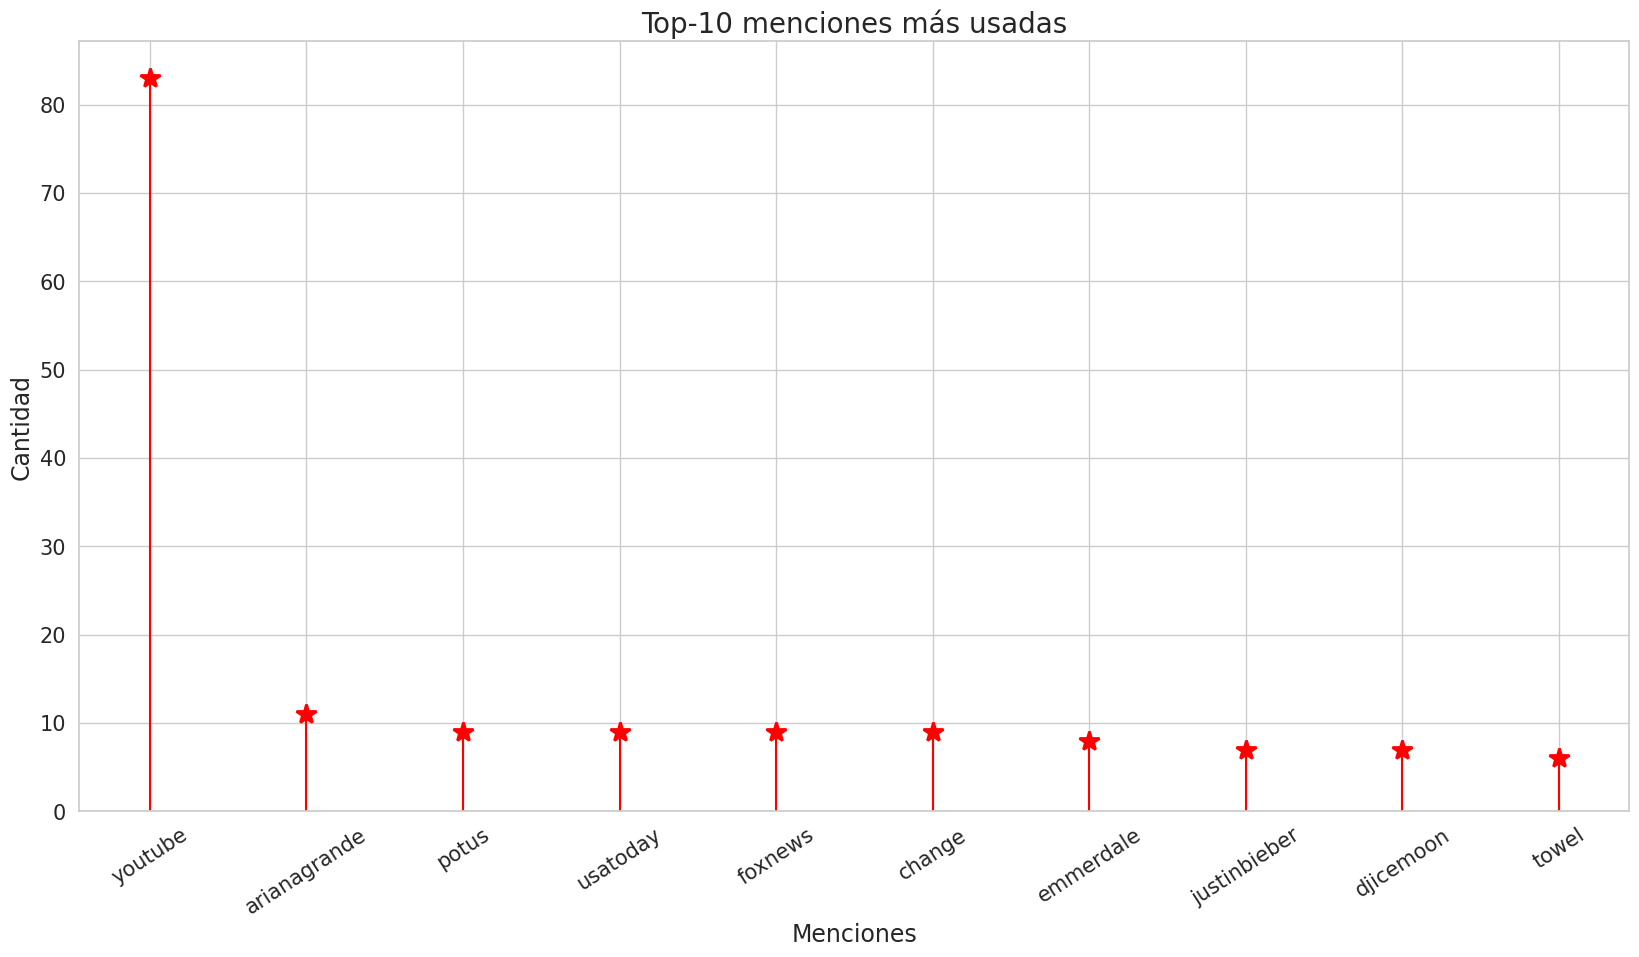

In [93]:
menciones = {}
for row in df_menciones['mentions']:
    for mencion in row.split(", "):
        if mencion in menciones:
            menciones[mencion] += 1
        else:
            menciones[mencion] = 1

mentions = pd.DataFrame([v for v in menciones.values()], columns = ['total'], index = [k for k in menciones.keys()])\
.sort_values('total', ascending=False)

(markerline, stemlines, baseline) = plt.stem(mentions.head(10).index, mentions.head(10).total)
plt.setp(markerline, marker='*', markersize=15, markeredgewidth=2, color='red')
plt.setp(stemlines, color='red')
plt.setp(baseline, visible=False)
plt.title("Top-10 menciones más usadas", fontsize = 20)
plt.tick_params(axis = 'both', labelsize=15)
plt.xlabel('Menciones', fontsize = 17)
plt.ylabel('Cantidad', fontsize = 17)
plt.ylim(bottom=0)
plt.xticks(rotation = 33)

plt.show()

#### Ahora vamos analizar aquellos tweets que poseen URLs

In [94]:
url_reg = re.compile(r'https?://\S+|www\.\S+')

def buscar_urls(x):
    coincidencias = re.findall(url_reg, x)
    urls = ""
    for coincidencia in coincidencias:
        urls += ", {}".format(coincidencia.lower)
    return coincidencias

df_urls = dataframe.copy()
df_urls = df_urls.loc[df_urls['text'].str.contains(url_reg)]
df_urls['urls'] = df_urls['text'].map(lambda x: buscar_urls(x))
df_urls['urls amount'] = df_urls['urls'].str.len()

print("Cantidad de tweets con URLs: {}".format(len(df_urls)))
print("Cantidad de URLs en total: {}".format(df_urls['urls amount'].sum()))

Cantidad de tweets con URLs: 3971
Cantidad de URLs en total: 4723


Retomamos estos 3 análisis cuando hayamos analizado la veracidad de los tweets según su *target*

## Análisis de tweets por su veracidad (columna *target*)
#### Sabemos que, según el target, los tweets pueden ser verdaderos (target = 1) o falsos (target = 0). Vamos a analizar ambos tipos de tweets.

#### Tweets reales

In [95]:
df_real_tweets = dataframe[dataframe['target'] == 1]
df_real_tweets.sample(10)

,id,keyword,location,text,target,tweet lenght
2437,3500,derailed,"Arlington, VA and DC",@GerryConnolly @RepDonBeyer @timkaine Today's ...,1,137
7222,10341,weapons,NaN,Since the chemical-weapons 'red line' warning ...,1,137
2952,4243,drowned,India,Hundreds of migrants feared drowned off Libya:...,1,132
4361,6196,hijacker,NaN,Governor Allows Parole for School Bus Hijacker...,1,69
6326,9042,structural%20failure,"Berlin, Germany",1) 'Investigators say a Virgin Galactic spaces...,1,140
3320,4755,evacuate,//??//,Tonight is being quite interesting... A few mi...,1,117
4656,6621,inundated,Singapore,Myanmar's president urged people to leave a lo...,1,142
7220,10339,weapons,"Houston, TX",I'm sorry but if you have to resort to weapons...,1,142
5162,7361,obliterate,Cymru araul,@McCaineNL Think how spectacular it will look ...,1,98
7023,10067,typhoon,ngapain?,Obama Declares Disaster for Typhoon-Devastated...,1,136


In [96]:
print("En el dataset hay {} tweets reales".format(len(df_real_tweets)))

En el dataset hay 3271 tweets reales


#### Tweets falsos

In [97]:
df_fake_tweets = dataframe[dataframe['target'] == 0]
df_fake_tweets.sample(10)

,id,keyword,location,text,target,tweet lenght
6793,9732,tragedy,staggering on tenement roofs,@tanehisicoates even the second half has that ...,0,120
6675,9566,thunder,"Decatur, GA",@KristyLeeMusic brings her Alabama thunder bac...,0,107
6026,8612,seismic,Smash Manor/Kanto,@marek1330 *Zar cringes at the blows but doesn...,0,84
3938,5599,flood,New York,Spot Flood Combo 53inch 300W Curved Cree LED W...,0,139
881,1276,blood,Buenos Aires,*se pone a cantar crying lightning*,0,35
1628,2351,collapse,Worldwide.,åÈMGN-AFRICAå¨ pin:263789F4 åÈ Correction: Ten...,0,132
5384,7683,panic,East TN.,@biggangVH1 looks like George was having a pan...,0,61
2988,4295,drowning,NaN,@Homukami Only URs and SRs matter Rs you'll be...,0,98
5979,8539,screaming,JDB/LJC/AGB/TW/PLL,@justinbieber I AM SCREAMING HELL YES AHHHH ...,0,72
2053,2945,danger,Israel,In my experience if you're always angry and cr...,0,115


In [98]:
print("En el dataset hay {} tweets falsos".format(len(df_fake_tweets)))

En el dataset hay 4342 tweets falsos


#### Análisis estadistico de los tweets en funcion de su longitud y su target

In [99]:
df_statistics = dataframe.groupby('target').agg({'tweet lenght':['min','max','mean']})
level0 = df_statistics.columns.get_level_values(0)
level1 = df_statistics.columns.get_level_values(1)
df_statistics_one_dimension = df_statistics.copy()
df_statistics_one_dimension.columns = level0 + ' ' + level1
df_statistics_one_dimension

,tweet lenght min,tweet lenght max,tweet lenght mean
target,,,
0,7,157,95.71
1,14,151,108.11


#### Visualización del análisis anterior

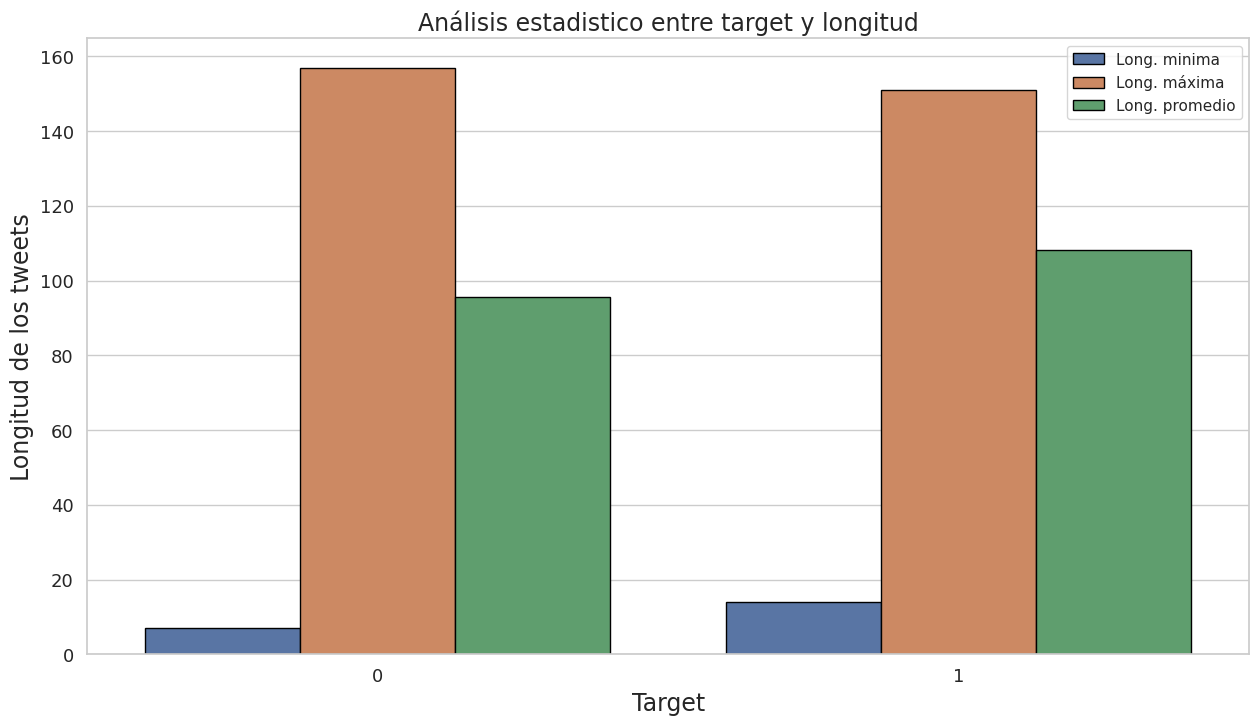

In [100]:
df_statistics_stacked = df_statistics.stack()

plt.figure(figsize = (15,8))
graphic = sns.barplot(x = 'target', y = 'tweet lenght', hue = 'level_1', data = df_statistics_stacked.reset_index(), edgecolor = 'black')
plt.xlabel("Target", fontsize = 17)
plt.ylabel("Longitud de los tweets", fontsize = 17)
plt.title("Análisis estadistico entre target y longitud", fontsize=17)
legend = graphic.legend()
legend.set_title("")
for t, l in zip(legend.texts,("Long. minima", "Long. máxima","Long. promedio")):
    t.set_text(l)
plt.tick_params(axis='both', labelsize = 13)

#### Cantidad de menciones y hashtags segun target.

In [101]:
df_targets = df_menciones.groupby('target').agg({'text':'count'})\
.join(df_hashtags.groupby('target').agg({'text': 'count'}), on = 'target', lsuffix = " mentions", rsuffix = " hashtags")
df_targets

,text mentions,text hashtags
target,,
0,1338,885
1,656,858


#### Cantidad de tweets con URL segun target.

In [102]:
real_tweets_with_url = df_urls[df_urls['target'] == 1]
fake_tweets_with_url = df_urls[df_urls['target'] == 0]
print("Cantidad de tweets reales con URL: {}".format(len(real_tweets_with_url)))
print("Cantidad de tweets falsos con URL: {}".format(len(fake_tweets_with_url)))

Cantidad de tweets reales con URL: 2172
Cantidad de tweets falsos con URL: 1799


## Análisis de la columna *keyword*

Sabemos que hay 61 valores nulos (o **NaN**) en esta columna, por lo que voy a deshacerme de ellos.

In [103]:
keywords = dataframe[~dataframe['keyword'].isnull()]
keywords['keyword'].to_frame().sample(10)

,keyword
6494,sunk
3883,flattened
6691,thunder
3702,fear
7481,wreck
3672,fatality
3050,earthquake
2266,deluged
5674,rescued
662,blaze


Vemos que varias keywords poseen los simbolos '%20', por lo que procedemos a eliminarlos gracias a la libreria **Re**.

In [104]:
keywords['keyword'] = keywords['keyword'].map(lambda x: re.sub(r'%20',' ', str(x)))
keywords['keyword'].to_frame().sample(20)

,keyword
5926,screamed
2972,drowning
4695,landslide
4009,floods
5433,police
832,blizzard
1206,buildings burning
944,blown up
5449,police
6131,siren


#### TOP-10 keywords mas usadas en tweets reales.

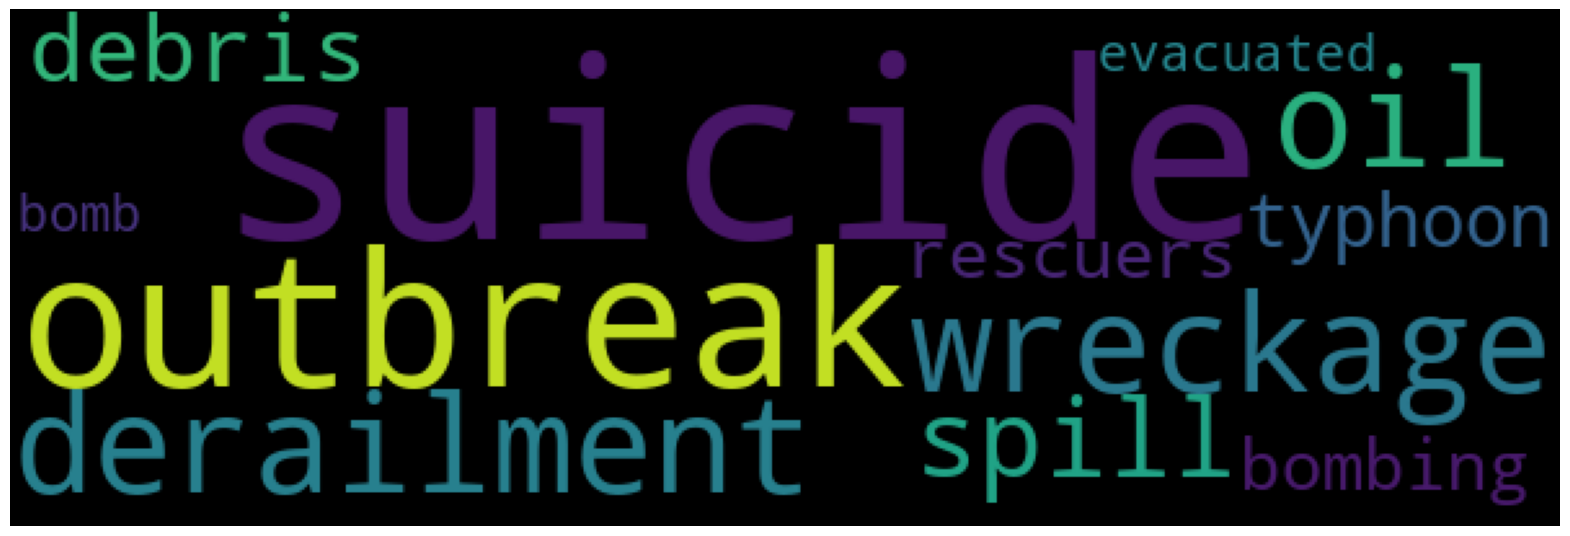

In [105]:
real_tweets_keywords = keywords[keywords['target'] == 1]
real_tweets_keywords = real_tweets_keywords['keyword'].value_counts().to_frame()
real_tweets_keywords.columns = ['keyword appearances']

keywords_string = ' '.join(real_tweets_keywords.head(10).index)
wordcloud = WordCloud(stopwords=STOPWORDS, background_color='black',
                      width=600,
                      height=200
                     ).generate(keywords_string)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

#### TOP-10 keywords mas usadas en tweets falsos.

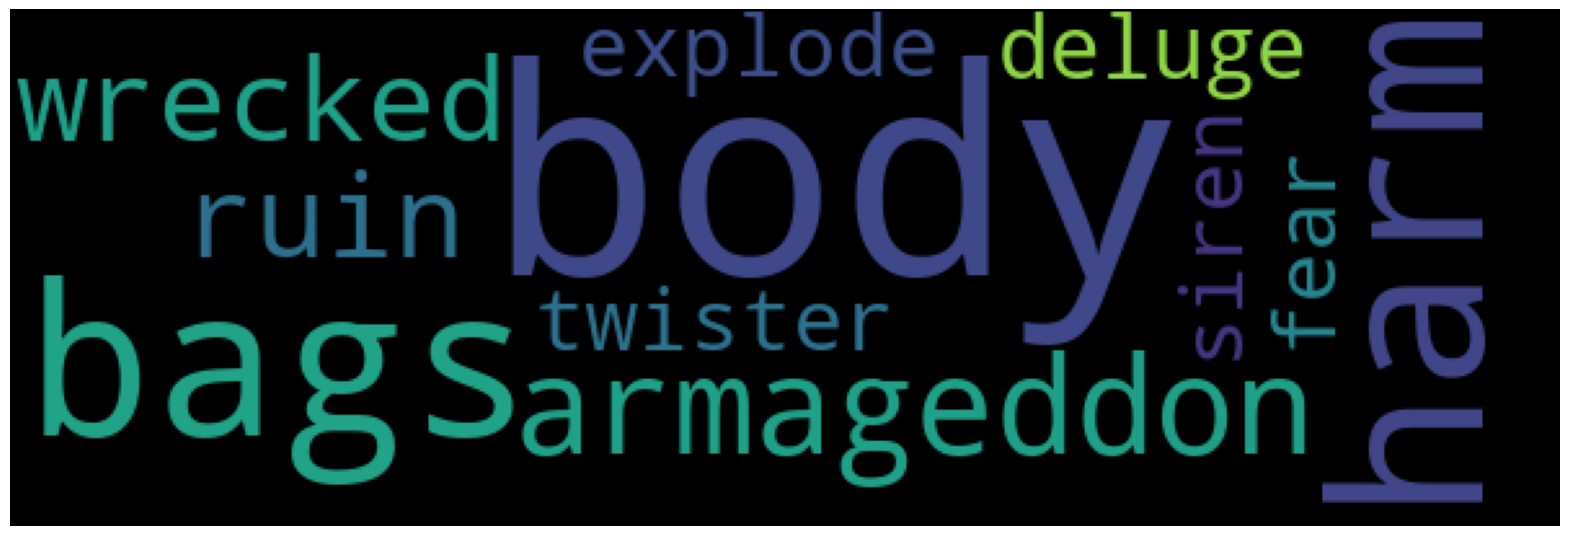

In [106]:
fake_tweets_keywords = keywords[keywords['target'] == 0]
fake_tweets_keywords = fake_tweets_keywords['keyword'].value_counts().to_frame()
fake_tweets_keywords.columns = ['keyword appearances']

keywords_string = ' '.join(fake_tweets_keywords.head(10).index)
wordcloud = WordCloud(stopwords=STOPWORDS, background_color='black',
                      width=600,
                      height=200
                     ).generate(keywords_string)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

#### Podríamos ver qué palabras más repetidas en las falsas, también se repiten en las verdaderas y viceversa, para ver si hay palabras que solo (o casi) aparecen en una de las dos.

In [107]:
merged = fake_tweets_keywords.reset_index().merge(real_tweets_keywords.reset_index(),on = 'index',suffixes=(' (fakes)', ' (reals)'))
merged = merged.rename(columns = {'index':'keyword'}).set_index('keyword')
merged['diff'] = abs(merged['keyword appearances (reals)'] - merged['keyword appearances (fakes)'])
merged = merged.sort_values(by = ["diff"], ascending = [False])
merged.head()

,keyword appearances (fakes),keyword appearances (reals),diff
keyword,,,
body bags,40,1,39
outbreak,1,39,38
typhoon,1,37,36
oil spill,1,37,36
ruin,36,1,35


#### Visualización lmplot: combina *regplot()* con *FacetGrid*. Se pretende que sea una interfaz conveniente para ajustar modelos de regresión a través de subconjuntos condicionales de un conjunto de datos

Text(17.31944444444445, 0.5, 'Apariciones en tweets reales')

<Figure size 1500x800 with 0 Axes>

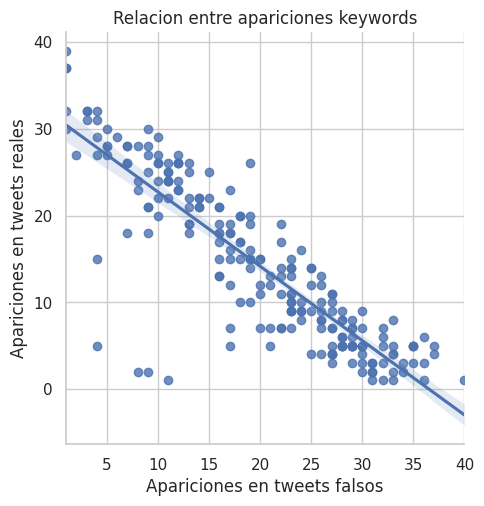

In [108]:
x = 'keyword appearances (fakes)'
y = 'keyword appearances (reals)'

plt.figure(figsize = (15,8))
graphic = sns.lmplot(x, y, data = merged, palette = "Set2", scatter = True, fit_reg = True)
plt.title('Relacion entre apariciones keywords')
plt.xlabel('Apariciones en tweets falsos')
plt.ylabel('Apariciones en tweets reales')


#### Para explicar un poco el gráfico: los puntos en la parte superior izquierda indican que hay keywords que aparecen muchas veces en tweets reales pero pocas veces en tweets falsos;  en la parte inferior derecha indican que hay keywords que aparecen muchas veces en tweets falsos, pero pocas en tweets reales. La linea es una regresión lineal.

#### En los análisis anteriores sobre keywords, vimos que hay muchas que estan relacionadas. Por ej: ablaze, ablazing. Ahora procedemos a buscar las raices de esas palabras clave.

In [109]:
stemmer = SnowballStemmer("english")
keywords['keyword'] = keywords['keyword'].apply(lambda x: stemmer.stem(str(x)))
keywords.sample(10)

,id,keyword,location,text,target,tweet lenght
4079,5798,hail,NaN,Thank you so so much to everyone for posting t...,0,102
5843,8349,ruin,texas,smokers that ruin that new car smell ????,0,41
5222,7461,obliter,"kissimmee,fl.",Why did God order obliteration of ancient Cana...,0,76
3030,4351,earthquak,Sydney,#3Novices : Renison mine sees seismic event ht...,1,140
2173,3116,debri,NaN,RÌ©union Debris Is Almost Surely From Flight 3...,1,102
6879,9862,traumatis,uk,go easy on her paul the poor woman has been tr...,0,71
7107,10183,violent storm,??? ???? ?f glory. ?,@Skarletan åÇ the storm. A violent swell of em...,0,66
5287,7554,outbreak,LAGOS,Families to sue over Legionnaires: More than 4...,1,136
5978,8538,scream,9/1/13,SCREAMING IN 22 DIFFERENT LANGUAGES http://t.c...,0,58
3569,5101,famin,NaN,The Adventures of Mineness #9 The Famine Is ...,1,73


#### Ahora vamos a buscar las raices de las 10 keywords mas usadas en tweets reales

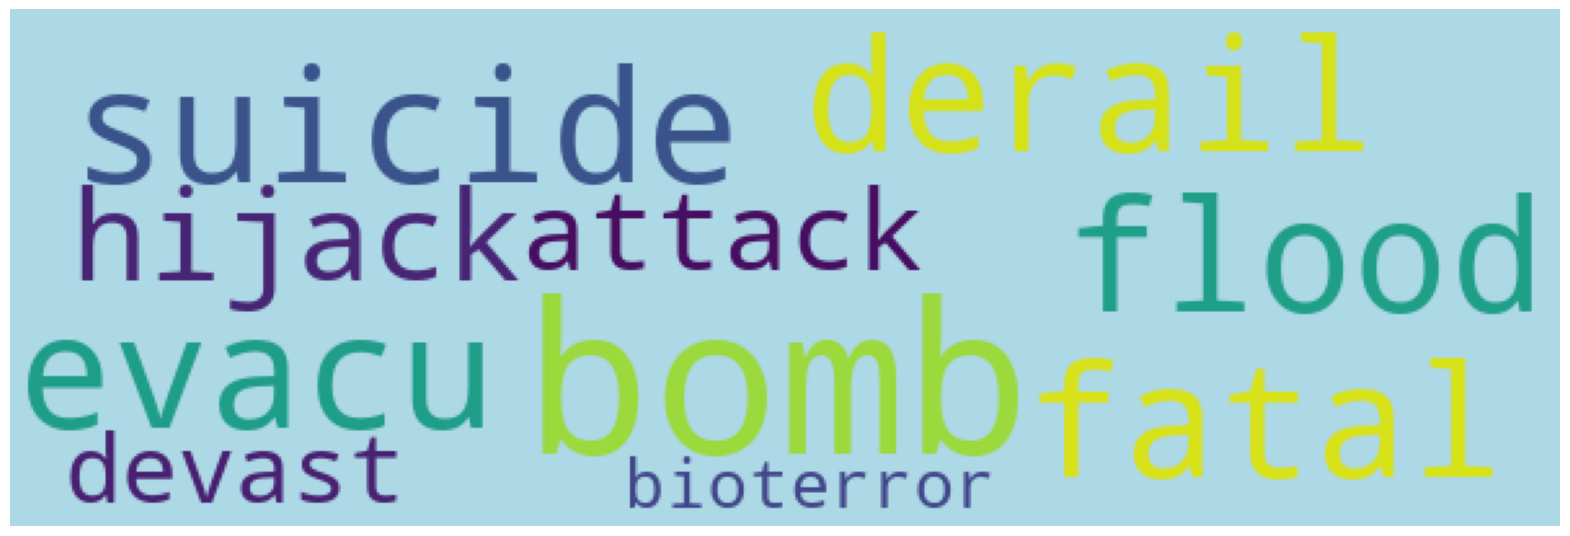

In [110]:
stem_real = keywords[keywords['target'] == 1]
stem_real = stem_real['keyword'].value_counts().to_frame()
stem_real.columns = ['keyword appearances']

keywords_string = ' '.join(stem_real.head(10).index)
wordcloud = WordCloud(stopwords=STOPWORDS, background_color='lightblue',
                      width=600,
                      height=200
                     ).generate(keywords_string)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()


#### Ahora lo mismo pero con las 10 más usadas en tweets falsos.

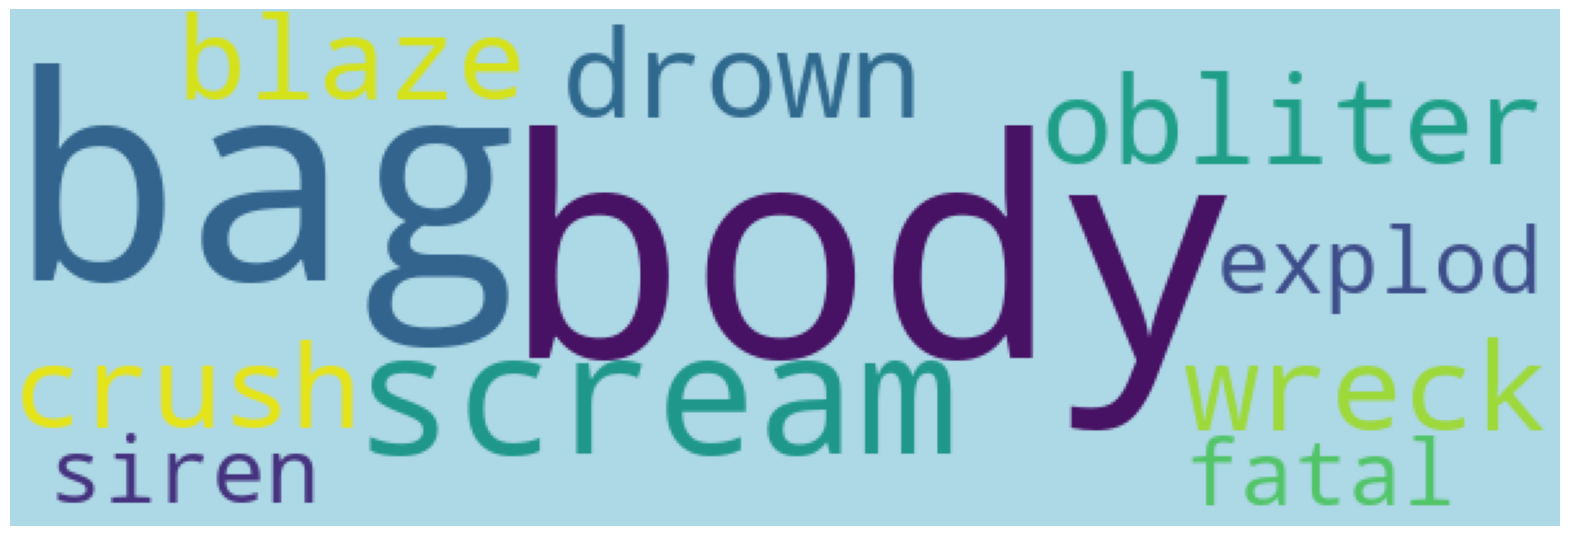

In [111]:
stem_fake = keywords[keywords['target'] == 0]
stem_fake = stem_fake['keyword'].value_counts().to_frame()
stem_fake.columns = ['keyword appearances']

keywords_string = ' '.join(stem_fake.head(10).index)
wordcloud = WordCloud(stopwords=STOPWORDS, background_color='lightblue',
                      width=600,
                      height=200
                     ).generate(keywords_string)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

## Análisis de la columna *location*
#### Vamos a eliminar los tweets cuya ubicacion sea un valor NaN o nulo, que ya vimos que son 2533


In [112]:
dataframe_location = dataframe[~dataframe['location'].isnull()]
dataframe_location.head()

,id,keyword,location,text,target,tweet lenght
31,48,ablaze,Birmingham,@bbcmtd Wholesale Markets ablaze http://t.co/l...,1,55
32,49,ablaze,Est. September 2012 - Bristol,We always try to bring the heavy. #metal #RT h...,0,67
33,50,ablaze,AFRICA,#AFRICANBAZE: Breaking news:Nigeria flag set a...,1,82
34,52,ablaze,"Philadelphia, PA",Crying out for more! Set me ablaze,0,34
35,53,ablaze,"London, UK",On plus side LOOK AT THE SKY LAST NIGHT IT WAS...,0,76


#### Sacamos los puntos finales de cada location.

In [113]:
dataframe_location['location'] = dataframe_location['location'].str.replace('.','')
dataframe_location.head()

,id,keyword,location,text,target,tweet lenght
31,48,ablaze,Birmingham,@bbcmtd Wholesale Markets ablaze http://t.co/l...,1,55
32,49,ablaze,Est September 2012 - Bristol,We always try to bring the heavy. #metal #RT h...,0,67
33,50,ablaze,AFRICA,#AFRICANBAZE: Breaking news:Nigeria flag set a...,1,82
34,52,ablaze,"Philadelphia, PA",Crying out for more! Set me ablaze,0,34
35,53,ablaze,"London, UK",On plus side LOOK AT THE SKY LAST NIGHT IT WAS...,0,76


#### Vamos a cambiar las ubicaciones que existan en la libreria GeoText

In [114]:
def localization(string):
   
    places = geotext.GeoText(string)
    cities = places.cities
    if len(cities) == 0:
        return string
    return cities[0]

dataframe_location['location'] = dataframe_location['location'].str.title()
dataframe_location['location'] = dataframe_location['location'].map(lambda x: localization(x))
dataframe_location.head()

,id,keyword,location,text,target,tweet lenght
31,48,ablaze,Birmingham,@bbcmtd Wholesale Markets ablaze http://t.co/l...,1,55
32,49,ablaze,Bristol,We always try to bring the heavy. #metal #RT h...,0,67
33,50,ablaze,Africa,#AFRICANBAZE: Breaking news:Nigeria flag set a...,1,82
34,52,ablaze,Philadelphia,Crying out for more! Set me ablaze,0,34
35,53,ablaze,London,On plus side LOOK AT THE SKY LAST NIGHT IT WAS...,0,76


#### ¿En qué ubicación se redactaron la mayoria de los tweets?

In [115]:
location_appearances = dataframe_location.copy()
location_appearances['appearances'] = 1
location_appearances = location_appearances.groupby(['location','target'],as_index=False).agg({'appearances':'sum'})
location_appearances = location_appearances.sort_values('appearances', ascending = False)
location_appearances = location_appearances[location_appearances['appearances'] >= 10]
location_appearances.head()

,location,target,appearances
1784,New York,0,90
2691,Usa,1,70
1508,London,0,65
1785,New York,1,38
2690,Usa,0,38


#### TOP-10 de ubicaciones donde se hayan redactado tweets reales.

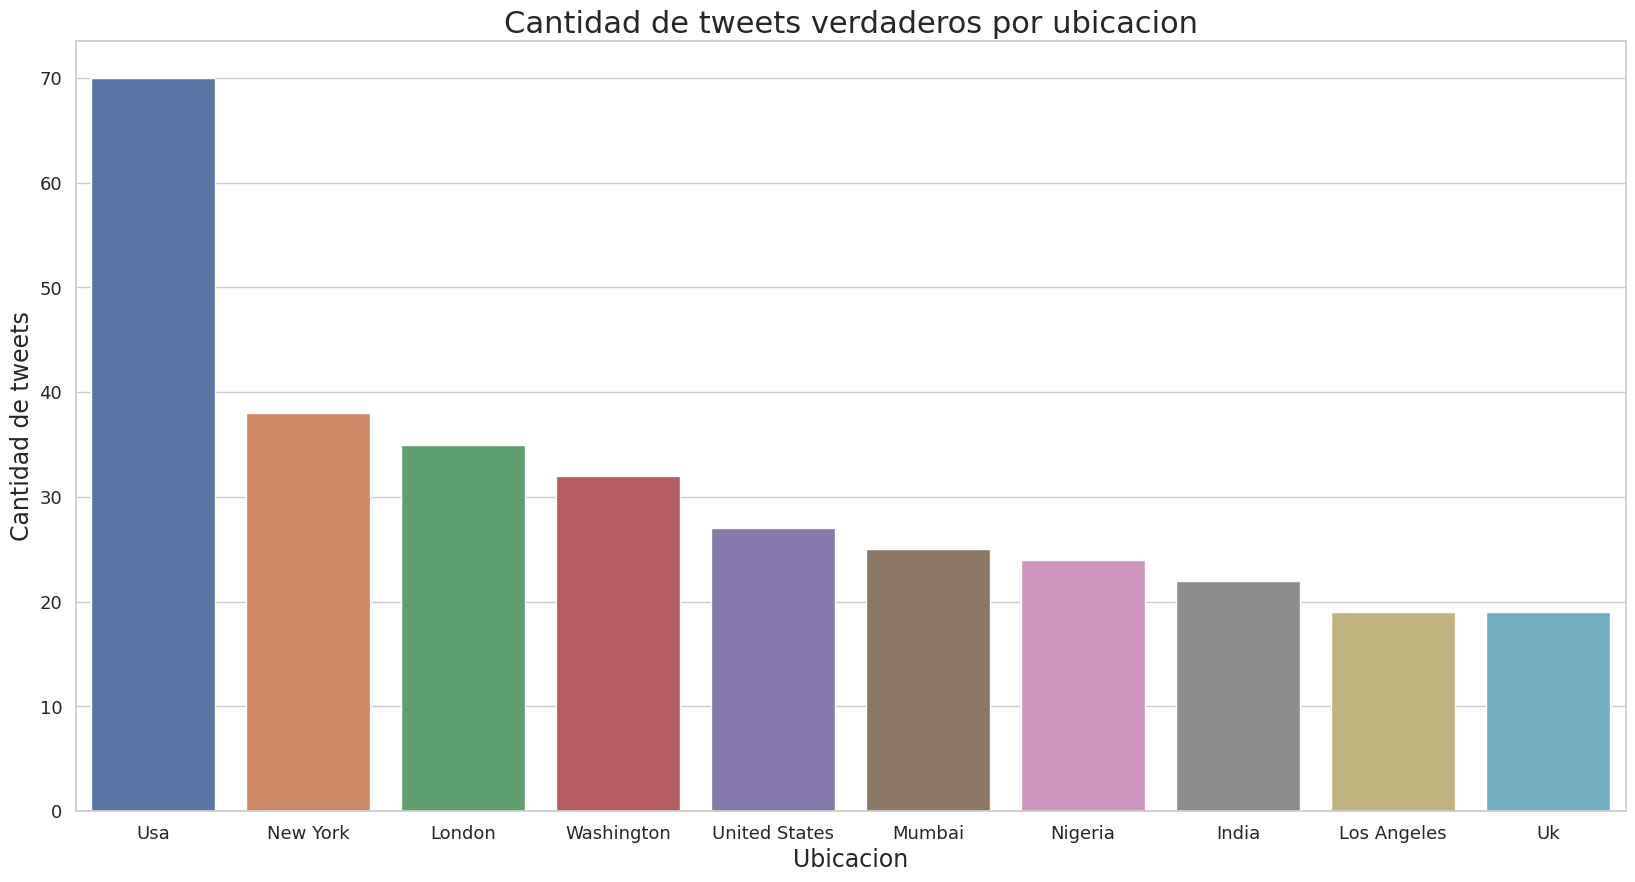

In [116]:
real_tweets_location = location_appearances[location_appearances['target'] == 1]

ax = sns.barplot(x = "location", y = "appearances", data = real_tweets_location.head(10))
ax.set_title('Cantidad de tweets verdaderos por ubicacion', fontsize=22)
ax.set_xlabel('Ubicacion', fontsize=17)
ax.set_ylabel('Cantidad de tweets', fontsize=17)
ax.tick_params(axis='both', labelsize = 13)

#### TOP-10 de ubicaciones donde se hayan redactado tweets falsos.

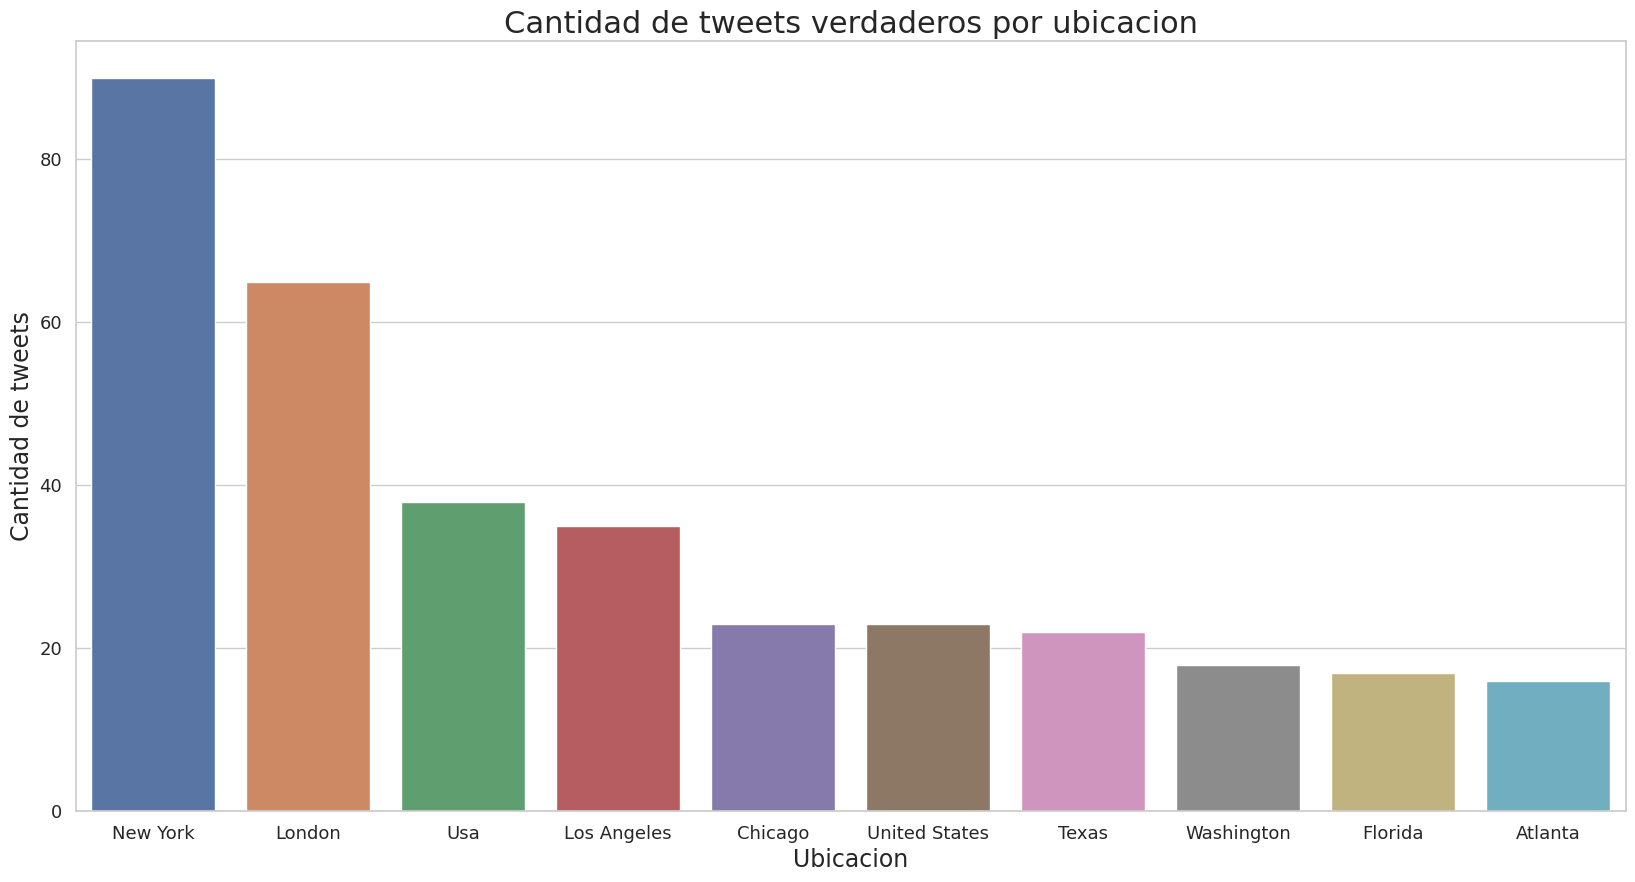

In [117]:
fake_tweets_location = location_appearances[location_appearances['target'] == 0]

ax = sns.barplot(x = "location", y = "appearances", data = fake_tweets_location.head(10))
ax.set_title('Cantidad de tweets verdaderos por ubicacion', fontsize=22)
ax.set_xlabel('Ubicacion', fontsize=17)
ax.set_ylabel('Cantidad de tweets', fontsize=17)
ax.tick_params(axis='both', labelsize = 13)

## Análisis exploratorio de datos provenientes de Estados Unidos
#### El *¿Por qué?* de éste análisis
Notamos que para un gran porcentje de tweets la ubicación conocida es o bien su país de procedencia, siendo este Estados Unidos, o bien un estado o ciudad ubicados dentro del territorio estadounidense.

#### Agregamos al dataframe dos columnas: 1.Columna **located**: contendrá la ubicación detectada. 2.Columna **location_type**: me servirá para saber el tipo de ubicación, es decir si corresponde al pais(P), a un estado(E) o a una ciudad(C)

In [118]:
dataframe_usa = dataframe[~dataframe['location'].isnull()]
dataframe_usa['located'] = '-'
dataframe_usa['location_type'] = '-'
dataframe_usa.head()

,id,keyword,location,text,target,tweet lenght,located,location_type
31,48,ablaze,Birmingham,@bbcmtd Wholesale Markets ablaze http://t.co/l...,1,55,-,-
32,49,ablaze,Est. September 2012 - Bristol,We always try to bring the heavy. #metal #RT h...,0,67,-,-
33,50,ablaze,AFRICA,#AFRICANBAZE: Breaking news:Nigeria flag set a...,1,82,-,-
34,52,ablaze,"Philadelphia, PA",Crying out for more! Set me ablaze,0,34,-,-
35,53,ablaze,"London, UK",On plus side LOOK AT THE SKY LAST NIGHT IT WAS...,0,76,-,-


Se comenzará con el proceso de detección de ubicaciones relacionadas a Estados Unidos. Se irá de lo más específico a lo más global(ciudad->estado->pais) con el objetivo de no perder información en el camino.

#### Para ayudarnos en el análisis vamos a utilizar un archivo csv el cual contiene todos los estados y ciudades de Estados unidos

In [119]:
united_states = pd.read_csv('archivo.csv')
united_states.dropna(inplace=True)
united_states.head()

,City,State
0,Abilene,Texas
1,Akron,Ohio
2,Albuquerque,New Mexico
3,Alexandria,Virginia
4,Allentown,Pennsylvania


#### OBSERVACIÓN IMPORTANTE
**New York** es nombre tanto de ciudad como de estado. Los registros que se correspondan con este string serán considerados que pertenecen a la ciudad de Nueva York y seran considerados tambien cuando se haga referencia a dicho estado.

In [120]:
def detectar_iguales(ciudad):
    estados = united_states['State'].drop_duplicates().tolist()
    if str(ciudad) in estados:
        return ciudad
    return None

united_states['City'].transform(detectar_iguales).value_counts()

New York    1
Name: City, dtype: int64

### Paso 1: detectar ciudad
En primer lugar vamos detectar todos aquellos registros cuya ubicación contenga el nombre de alguna ciudad de Estados Unidos. Con este objetivo se define la siguiente función:

In [121]:
def detectar_ciudades(x):
    ciudades = united_states['City'].tolist()
    for ciudad in ciudades:
        if ciudad.upper() in str(x).upper():
            return ciudad
    return "-"

result = dataframe_usa[dataframe_usa['located']=="-"]['location'].transform(detectar_ciudades)
for indice in result.index.tolist():
    deteccion = result.loc[indice]
    if deteccion != '-':
        dataframe_usa.loc[indice,'located']= deteccion
        dataframe_usa.loc[indice,'location_type']='C'
        
dataframe_usa['location_type'].value_counts()

-    3987
C    1093
Name: location_type, dtype: int64

Hasta el momento tenemos detectada la procedencia de 1093 registros provenientes de Estados Unidos.Hasta el momento tenemos detectada la procedencia de 1093 registros provenientes de Estados Unidos.

### Paso 2: detectar estados
Vamos a investigar los registros que aún no fueron localizados. La intención es detectar todos aquellos registros cuya ubicación contenga un estado de Estados Unidos.
#### Definamos una función que me permita detectar si un string coincide con el nombre de un estado de Estados Unidos.

In [122]:
def detectar_estados(x):
    """indica si una cadena es exactamente igual al nombre de un estado de Estados Unidos"""
    estados = united_states['State'].drop_duplicates().tolist()
    
    for estado in estados:
        if estado.upper() in str(x).upper():
            return estado
    return "-"

result = dataframe_usa[dataframe_usa['located'] == '-']['location'].transform(detectar_estados)
for indice in result.index.tolist():
    deteccion = result.loc[indice]
    if deteccion != '-':
        dataframe_usa.loc[indice,'located'] = deteccion
        dataframe_usa.loc[indice,'location_type'] = 'E'
        
dataframe_usa['location_type'].value_counts()

-    3527
C    1093
E     460
Name: location_type, dtype: int64

### Paso 3: detectar pais
Solo nos queda detectar todos aquellos registros que contienen explicitamente el nombre del pais en Estados Unidos en cualquiera de sus variantes
#### Se crea entonces una función que será la encargada de hacer las comparaciones

In [123]:
def reconocer_estados_unidos(x):
    
    "Indica si una cadena contiene la palabra estados unidos en alguna de sus variantes"
    posibilidades = ['UNITED STATES','USA','US','U.S.A','EE.UU.','EEUU','EE UU','ESTADOS UNIDOS','840']
    for posibilidad in posibilidades:
        if posibilidad.upper() == str(x).upper():
            return 'United States'
    return "-"

result = dataframe_usa[dataframe_usa['located']=='-']['location'].transform(reconocer_estados_unidos)
for indice in result.index.tolist():
    deteccion = result.loc[indice]
    if deteccion != '-':
        dataframe_usa.loc[indice,'located'] = deteccion
        dataframe_usa.loc[indice,'location_type'] = 'P'

dataframe_usa['location_type'].value_counts()

-    3358
C    1093
E     460
P     169
Name: location_type, dtype: int64

Se detectaron 169 registros contienen como ubicación alguna referencia a Estados Unidos. **Total detectados: 1722**.
### Paso 4: agregamos algunos manualmente
Se revisan algunos casos particulares.
Se observa algunos registros que no fueron detectados, podemos agregarlos a mano

In [124]:
list_unmatched_states = ['NYC','NY','Brooklyn, NY']
indices = dataframe_usa[dataframe_usa['location'].isin(list_unmatched_states)].index.tolist()

for indice in indices:
    dataframe_usa.loc[indice,'located'] = 'New York'
    dataframe_usa.loc[indice,'location_type'] = 'C'
    
indices = dataframe_usa[dataframe_usa['location'] == "Haddonfield, NJ"].index.tolist()
for indice in indices:
    dataframe_usa.loc[indice,'located'] = 'New Jersey'
    dataframe_usa.loc[indice,'location_type'] = 'E'
    
dataframe_usa['location_type'].value_counts()

-    3331
C    1116
E     464
P     169
Name: location_type, dtype: int64

Resultado final: **1749 registros localizados**.

Ahora vemos como quedó nuestro dataframe sobre el cual realizaremos un nuevo análissi exploratorio

In [125]:
dataframe_usa = dataframe_usa[dataframe_usa['location_type'] != '-'].drop('location',axis=1)
dataframe_usa.sample(10)

,id,keyword,text,target,tweet lenght,located,location_type
6579,9417,survivors,Molecularly targeted cancer therapy for his #L...,0,127,Philadelphia,C
1962,2826,cyclone,Cyclone Komen devastates families in Myanmar t...,1,106,Vancouver,C
3354,4800,evacuated,KATUNews: #SR14 remains closed as brush fire b...,1,118,Portland,C
2986,4292,drowning,Drowning in Actavis suicide,0,27,Pittsburgh,C
6774,9706,tornado,Tornado has to make the playoffs. They have 3 ...,0,114,Kent,C
648,939,blaze,Welcome @djryanwolf @djcoreygrand @djknyce @dj...,0,137,Atlanta,C
1363,1966,burning%20buildings,Dudes will thoroughly express how stupid black...,1,138,Oakland,C
2144,3077,deaths,No two cases don't constitute an epidemic. htt...,1,96,Phoenix,C
6067,8667,sinkhole,150-Foot Sinkhole Opens In Lowndes County Resi...,1,81,New Jersey,E
3999,5680,floods,Typhoon Soudelor approaches after 7 killed 2 m...,1,117,United States,P


Ya limpio nuestro set de datos, iniciaremos un análisis sobre la veracidad de los tweets sobre desastres emitidos desde Estados Unidos. La idea es analizar la veracidad de los tweet a nivel país e intentar identificar fuentes de tweets falsos dentro del territorio estadounidense. Por otra parte se intentará descifrar si hay alguna relación entre la longitud de los tweet y su contenido con la veracidad o la falsedad de los mismos.

In [126]:
amount_tweets_usa = dataframe_usa['target'].value_counts()
amount_tweets_usa

0    962
1    787
Name: target, dtype: int64

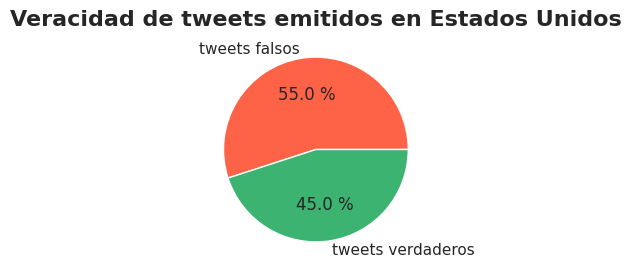

In [127]:
colores = ['tomato','mediumseagreen']
plt.figure(figsize=(3,3))
plt.title('Veracidad de tweets emitidos en Estados Unidos',fontsize=16,fontweight='bold')
plt.pie(dataframe_usa['target'].value_counts(), labels=['tweets falsos','tweets verdaderos'],autopct="%0.1f %%",colors = colores)
plt.show()

Analicemos la veracidad de los tweets por estado. Veamos si encontramos algún estado en donde: o bien la diferencia porcentual encontrada a nivel país se agrande o bien se invierta la tendencia y detectemos que la cantidad de tweets verdaderos supera a los falsos.

#### Seleccionemos aquellos tweets para los que tenemos información sobre su estado

In [128]:
tweets_by_state = dataframe_usa[dataframe_usa['location_type'] == 'E']
tweets_by_state = tweets_by_state.rename(columns={'located':'State'})
tweets_by_state.head()

,id,keyword,text,target,tweet lenght,State,location_type
50,73,ablaze,Deputies: Man shot before Brighton home set ab...,1,73,Ohio,E
72,104,accident,Reported motor vehicle accident in Curry on He...,1,139,Alabama,E
74,107,accident,I-77 Mile Marker 31 South Mooresville Iredell...,1,90,North Carolina,E
78,113,accident,I-77 Mile Marker 31 to 40 South Mooresville I...,1,95,North Carolina,E
94,136,accident,Suffield Alberta Accident https://t.co/bPTmlF4P10,1,49,Montana,E


#### Seleccionemos ahora aquellos tweets para los que conocemos su ciudad pero  no su estado y obtengamos el estado desde el archivo que utilizamos anteriormente

In [129]:
tweets_by_city = dataframe_usa[dataframe_usa['location_type']=='C']\
.merge(united_states,left_on = 'located',right_on = 'City',how = 'left')
tweets_by_city['located'] = tweets_by_city['State']
tweets_by_city = tweets_by_city.drop(columns = ['State'])
tweets_by_city = tweets_by_city.rename(columns={'located':'State'})
tweets_by_city.head()

,id,keyword,text,target,tweet lenght,State,location_type,City
0,48,ablaze,@bbcmtd Wholesale Markets ablaze http://t.co/l...,1,55,Alabama,C,Birmingham
1,52,ablaze,Crying out for more! Set me ablaze,0,34,Pennsylvania,C,Philadelphia
2,66,ablaze,How the West was burned: Thousands of wildfire...,1,97,North Carolina,C,Greensboro
3,77,ablaze,Police: Arsonist Deliberately Set Black Church...,1,95,California,C,Anaheim
4,82,ablaze,They sky was ablaze tonight in Los Angeles. I'...,0,119,Florida,C,Hollywood


#### Combinamos ambos dataframes en una misma tabla

In [130]:
tweets_merged = pd.concat([tweets_by_state, tweets_by_city])
tweets_merged.head()

,id,keyword,text,target,tweet lenght,State,location_type,City
50,73,ablaze,Deputies: Man shot before Brighton home set ab...,1,73,Ohio,E,NaN
72,104,accident,Reported motor vehicle accident in Curry on He...,1,139,Alabama,E,NaN
74,107,accident,I-77 Mile Marker 31 South Mooresville Iredell...,1,90,North Carolina,E,NaN
78,113,accident,I-77 Mile Marker 31 to 40 South Mooresville I...,1,95,North Carolina,E,NaN
94,136,accident,Suffield Alberta Accident https://t.co/bPTmlF4P10,1,49,Montana,E,NaN


#### Calculamos la cantidad de tweets falsos y verdaderos por estado

In [131]:
tweets_amount = tweets_merged.groupby(['State']).agg({'target':'value_counts'})
tweets_amount.columns = ['amount']
tweets_amount.head()

amount
State   target        
Alabama 1           17
        0           10
Alaska  1            4
        0            3
Arizona 1           15

#### Calculamos la diferencia entre la cantidad de tweets verdaderos y falsos. De esta forma en todos aquellos estados en donde haya más tweet verdaderos que verdaderos el resultado será negativo y será positivo en el caso contrario.

In [132]:
diff = tweets_amount.unstack().reset_index()
diff.columns=['State','0','1']
diff.fillna(0,inplace=True)
diff['diff'] = diff['1'] - diff['0']
diff.head()

,State,0,1,diff
0,Alabama,10.00,17.00,7.00
1,Alaska,3.00,4.00,1.00
2,Arizona,10.00,15.00,5.00
3,Arkansas,1.00,0.00,-1.00
4,California,147.00,131.00,-16.00


#### Hagamos ahora una visualización que nos permita apreciar los resultados obtenidos: Carguemos un archivo shapefile del que extraeremos información para poder realizar los gráficos.

In [133]:
usa = gpd.read_file('shapefiles/USA_States.shp')
usa.drop(columns = ['STATE_FIPS','STATE_ABBR'],inplace=True)
usa.head(5)

,STATE_NAME,geometry
0,Washington,"MULTIPOLYGON (((-122.40202 48.22522, -122.4628..."
1,Montana,"POLYGON ((-111.47543 44.70216, -111.48080 44.6..."
2,Maine,"MULTIPOLYGON (((-69.77728 44.07415, -69.85993 ..."
3,North Dakota,"POLYGON ((-98.73044 45.93827, -99.00683 45.939..."
4,South Dakota,"POLYGON ((-102.78838 42.99530, -103.00588 42.9..."


#### Añadimos nuestros resultados al archivo

In [134]:
usa = usa.merge(diff,how = 'left',right_on = 'State',left_on = 'STATE_NAME')
usa.drop(columns=['State'],inplace=True)
usa.fillna(0,inplace=True)


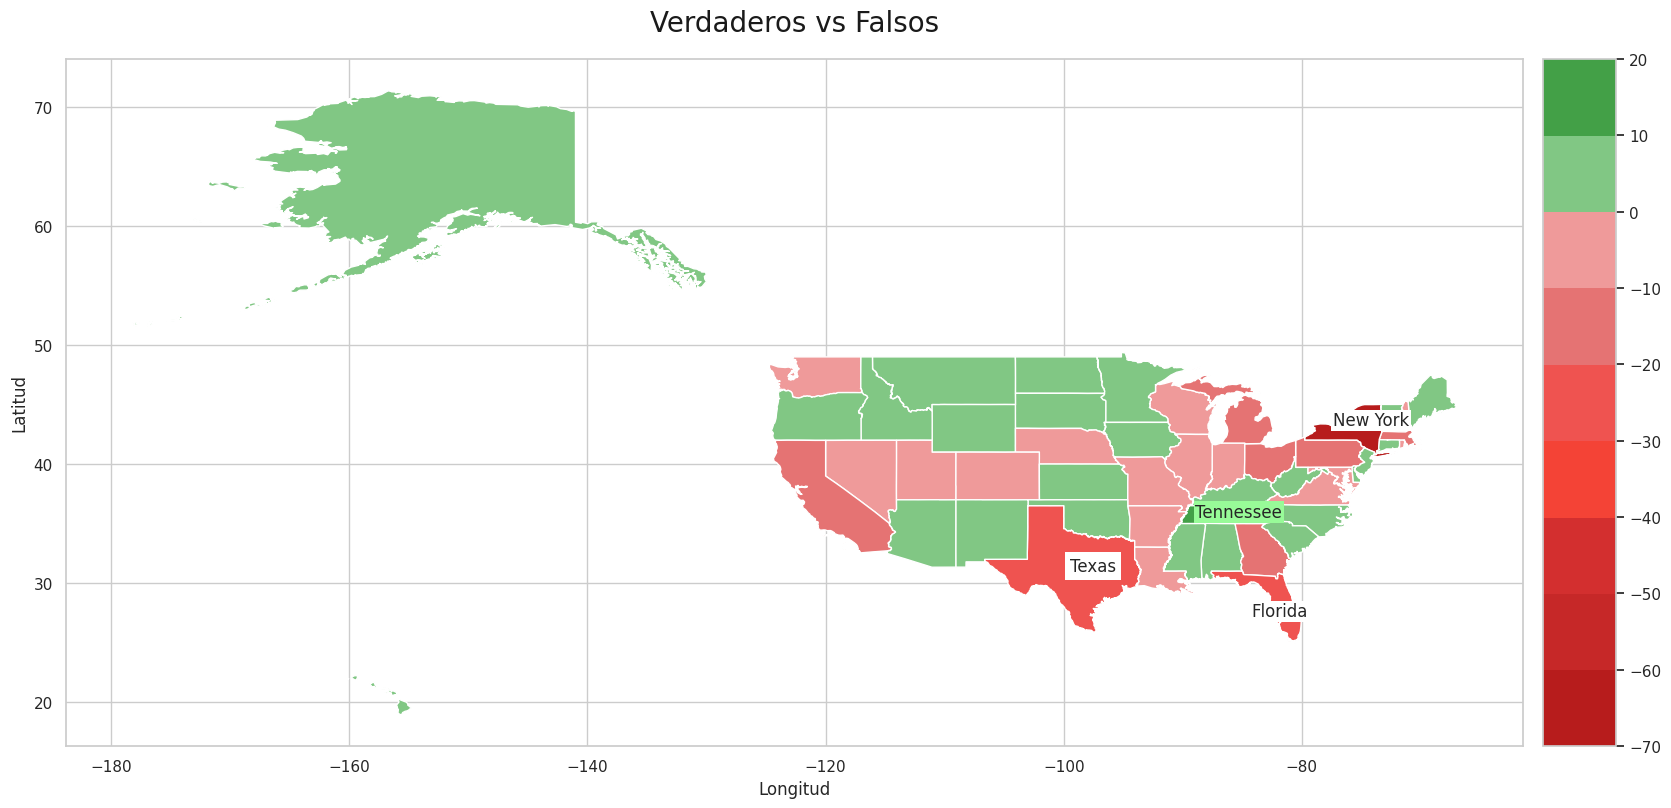

In [135]:

fig, ax = plt.subplots(figsize=(20, 20))

# Control del título y los ejes
ax.set_title('Verdaderos vs Falsos', 
             pad = 20, 
             fontdict={'fontsize':20, 'color': 'k'})
ax.set_xlabel('Longitud')
ax.set_ylabel('Latitud')
 
# Añadir la leyenda separada del mapa
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.2) 

#Colores
cmap = colors.ListedColormap(['#b71c1c', '#c62828', '#d32f2f','#f44336', '#ef5350','#e57373','#ef9a9a','#81c784','#43a047'])
boundaries = [-70, -60, -50, -40, -30, -20,-10,0,10,20]
norm = colors.BoundaryNorm(boundaries, cmap.N, clip=True)

#Agrego etiquetas
plt.text(-330, -28, 'New York', bbox=dict(boxstyle='square,pad=0.1', fc='white', ec='none')) # 300m x offset added.
plt.text(-655, -47, 'Texas', bbox=dict(boxstyle='square,pad=0.3', fc='white', ec='none')) # 300m x offset added.
plt.text(-430, -53, 'Florida', bbox=dict(boxstyle='square,pad=0.1', fc='white', ec='none')) # 300m x offset added.
plt.text(-500, -40, 'Tennessee', bbox=dict(boxstyle='square,pad=0.1', fc='palegreen', ec='none')) # 300m x offset added.

# Generar y cargar el mapa
usa.plot(column ='diff', ax=ax,legend=True, cax=cax, zorder=5,cmap=cmap,norm=norm)
plt.show()
plt.close()

**Conclusión:** Se observa que en la mayoria de los estados la situación es pareja. Solo hay un estado en donde la cantidad de tweets verdaderos supera a los falsos en mas de 10 unidades, el estado de Tennessee. Sin embargo hay varios estados en donde la cantidad de tweets falsos supera a los verdaderos en más de 10, Siendo la diferencia muy marcada en Florida, Texas y New york siendo este último dónde la situación es mucho más preocupante.

#### Otro análisis interesante es chequear si hay alguna relación entre la longitud de los tweets y su veracidad

In [136]:
df_statistics_usa = dataframe_usa.groupby('target').agg({'tweet lenght':['min','max','mean']})
level0 = df_statistics_usa.columns.get_level_values(0)
level1 = df_statistics_usa.columns.get_level_values(1)
df_statistics_one_dimension = df_statistics_usa.copy()
df_statistics_one_dimension.columns = level0 + ' ' + level1
df_statistics_one_dimension

,tweet lenght min,tweet lenght max,tweet lenght mean
target,,,
0,11,147,103.30
1,30,143,108.61


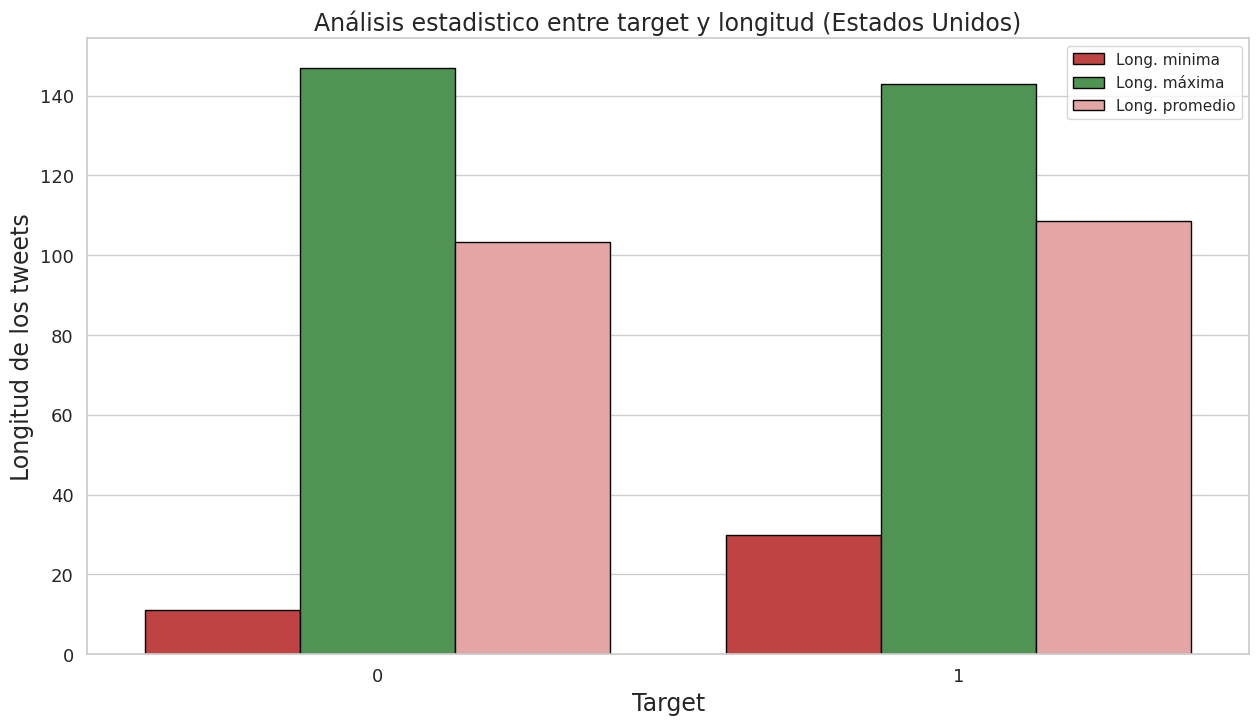

In [172]:
df_statistics_stacked = df_statistics_usa.stack()

plt.figure(figsize = (15,8))
graphic = sns.barplot(x = 'target', y = 'tweet lenght', hue = 'level_1', data = df_statistics_stacked.reset_index(),
                      edgecolor = 'black', palette = ['#d32f2f','#43a047','#ef9a9a'])
plt.xlabel("Target", fontsize = 17)
plt.ylabel("Longitud de los tweets", fontsize = 17)
plt.title("Análisis estadistico entre target y longitud (Estados Unidos)", fontsize=17)
legend = graphic.legend()
legend.set_title("")
for t, l in zip(legend.texts,("Long. minima", "Long. máxima","Long. promedio")):
    t.set_text(l)
plt.tick_params(axis='both', labelsize = 13)

#### Se observa que los tweet verdaderos son en promedio más largos que los tweet falsos. Sin embargo tanto el tweet mas corto como más largo son falsos.

#### Enfoquemosnos ahora en las diferentes ciudades de USA. Encontremos cuales de ellas son las principales emisoras de twets y en cuales longitud de los tweet falsos y verdaderos se enecuentran por encima y por debajo de los respectivos promedios

In [138]:
tweets_by_city = dataframe_usa[dataframe_usa['location_type'] == 'C']
tweets_by_city.head(5)

,id,keyword,text,target,tweet lenght,located,location_type
31,48,ablaze,@bbcmtd Wholesale Markets ablaze http://t.co/l...,1,55,Birmingham,C
34,52,ablaze,Crying out for more! Set me ablaze,0,34,Philadelphia,C
46,66,ablaze,How the West was burned: Thousands of wildfire...,1,97,Greensboro,C
53,77,ablaze,Police: Arsonist Deliberately Set Black Church...,1,95,Anaheim,C
58,82,ablaze,They sky was ablaze tonight in Los Angeles. I'...,0,119,Hollywood,C


#### Promedio por ciudad y target

In [139]:
def supera_promedio(target,promedio):
    if (target==1 and promedio>=df_statistics_one_dimension.loc[1,'tweet lenght mean'])\
    or (target==0 and promedio>=df_statistics_one_dimension.loc[0,'tweet lenght mean']):
        return True
    return False

totals = tweets_by_city.groupby(['located','target']).agg({'tweet lenght':['sum','count']})
totals.columns = ['sum','amount']
totals['avg'] = (totals['sum']/totals['amount'])
totals.reset_index(inplace=True)
totals['exceeds_avg']= totals.apply(lambda x: supera_promedio(x.target,x.avg),axis=1)
totals.drop(columns=['sum'],inplace=True)


totals = totals[totals['target']==0].merge(totals[totals['target']==1],left_on='located',
                                           right_on='located',how='outer')

totals.rename(columns = {
    'located':'city',\
    'target_x':'target_t0',\
    'amount_x':'amount_t0',\
    'avg_x':'lenght_avg_t0',\
    'exceeds_avg_x':'exceeds_avg_t0',\
    'target_y':'target_t1',\
    'amount_y':'amount_t1',\
    'avg_y':'lenght_avg_t1',\
    'exceeds_avg_y':'exceeds_avg_t1'},inplace=True)
totals.drop(columns=['target_t0','target_t1'],inplace=True)

totals['exceeds_avg_t0'] = totals['exceeds_avg_t0'].fillna('False')
totals['exceeds_avg_t1']=totals['exceeds_avg_t1'].fillna('False')
totals.fillna(0,inplace=True)
totals.head(10)



,city,amount_t0,lenght_avg_t0,exceeds_avg_t0,amount_t1,lenght_avg_t1,exceeds_avg_t1
0,Albuquerque,1.00,121.00,True,1.00,49.00,False
1,Alexandria,1.00,95.00,False,3.00,112.33,True
2,Anchorage,1.00,135.00,True,2.00,77.00,False
3,Antioch,2.00,100.50,False,0.00,0.00,False
4,Arlington,4.00,107.25,True,2.00,134.50,True
5,Asheville,2.00,87.50,False,3.00,97.67,False
6,Athens,1.00,139.00,True,2.00,91.50,False
7,Atlanta,22.00,102.50,False,11.00,112.09,True
8,Augusta,2.00,113.50,True,0.00,0.00,False
9,"Aurora, I",1.00,116.00,True,0.00,0.00,False


#### ¿Que sucede en las principales ciudades emisoras?
Quedemonos ahora con las ciudades que tienen mayor relevancia, pidiendo como condición que la cantidad de tweets emitidos desde dicha ciudad sea por lo menos 30 y saquemos algunas conclusiones:

In [140]:
filter_30_tweets = totals[totals['amount_t0'] + totals['amount_t1'] >=30]
filter_30_tweets.head()

,city,amount_t0,lenght_avg_t0,exceeds_avg_t0,amount_t1,lenght_avg_t1,exceeds_avg_t1
7,Atlanta,22.00,102.50,False,11.00,112.09,True
22,Chicago,27.00,100.48,False,22.00,110.14,True
73,Los Angeles,35.00,110.29,True,20.00,118.80,True
88,New York,111.00,115.95,True,47.00,118.87,True
117,San Francisco,15.00,98.80,False,17.00,99.24,False


**Conclusión 1:**

De las 5 ciudades desde las que se emitieron más tweets, en 4 de ellas la cantidad de tweets falsos emitidos supera a la cantidad de tweets verdaderos. La exepción es San Francisco, aunque la diferencia es de solo 2 tweets. En contraposición al caso de San Francisco, en las restantes cuatro ciudades, la cantidad de tweets falsos supera a la de tweets verdaderos en por lo menos 5 tweets en el caso más leve.

#### Visualicemos esto

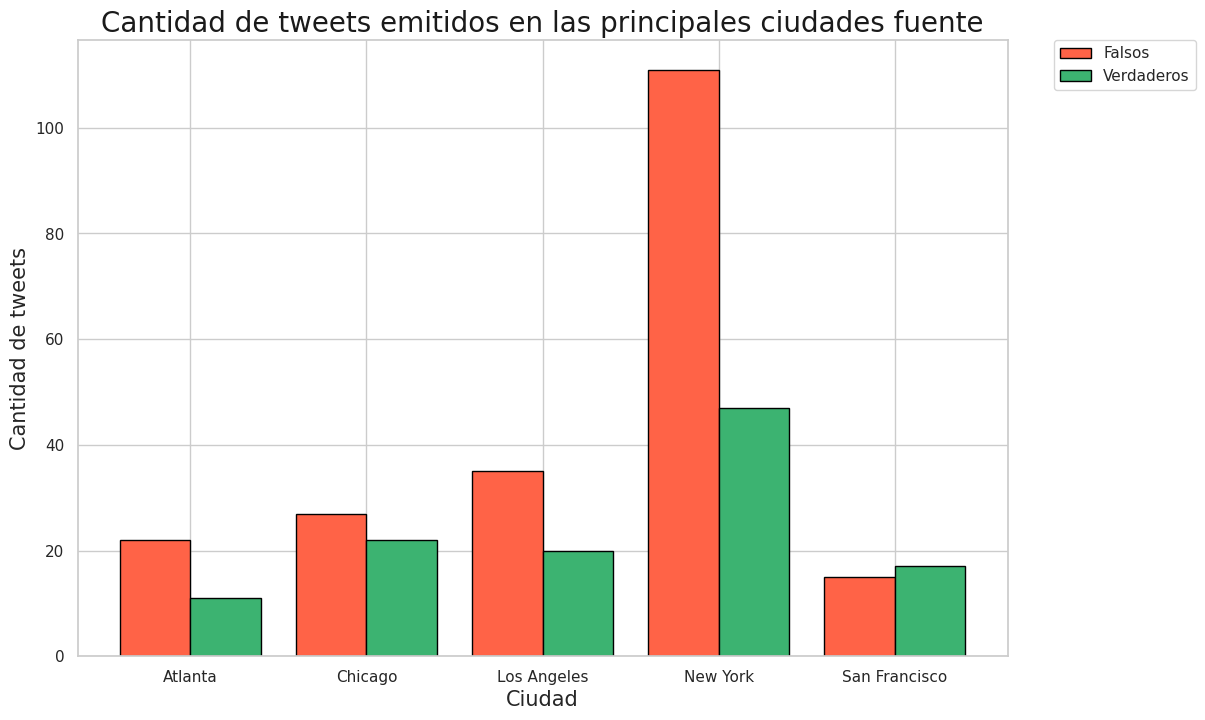

In [141]:
#Tamaño
fig, ax = plt.subplots(figsize=(12, 8))

#ancho barras
bar_width=0.4

#Aux para ubicar ejes
x = np.arange(5)

#grafico
plt.bar(x,height = filter_30_tweets['amount_t0'],color='tomato',label = 'Falsos',
        width=bar_width, edgecolor='black')
plt.bar(x+ bar_width,height = filter_30_tweets['amount_t1'],color='mediumseagreen',
        label='Verdaderos', width=bar_width, edgecolor='black')

#Nombre ejes
plt.ylabel('Cantidad de tweets', fontsize=15)
plt.xlabel('Ciudad', fontsize=15)

#Caja indicadora
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)


#titulo
plt.title('Cantidad de tweets emitidos en las principales ciudades fuente',color='k', fontsize=20)

#Acomodo nombre eje x
ax.set_xticks(x + bar_width / 2)
ax.set_xticklabels(filter_30_tweets.city.unique())

plt.show()

**Conclusión 2**:

A pesar de ser la unica ciudad con una cantidad significativa de tweets en donde la cantidad de tweets verdaderos supera a los falsos, San Francisco es la unica ciudad de las 5 que cumplen con los requisitos en donde la longitud de tweets verdaderos se encuentra por debajo de la longitud de tweets verdaderos a nivel pais.

Por otra parte resulta curioso que en las restantes 4 ciudades en donde se da el caso opuesto y la cantidad de falsos suspera a los verdaderos, en todas, la longitud promedio de tweets verdaderos supera a la longitud promedio de tweets verdaderos a nivel pais.

**Conclusión 3:**

En cuanto a la emisión de tweets falsos la situación es más variada.En tres de las cinco ciudades la longitud promedio de los tweets falsos no supera a al promedio en esa categoria a nivel pais, mientras que en las dos restantes si lo hace.

#### Cantidad de apariciones de hashtags, menciones y URL's en tweets provenientes de USA

In [170]:
df_usa_patterns = dataframe_usa.copy()
df_usa_patterns = df_usa_patterns.drop(['keyword','tweet lenght','location_type'],1)

df_usa_patterns['hashtags'] = df_usa_patterns['text'].apply(lambda x: buscar_hashtags(x))
df_usa_patterns['htg amount'] = df_usa_patterns['hashtags'].map(lambda x: len(x.split(',')))


df_usa_patterns['mentions'] = df_usa_patterns['text'].apply(lambda x: buscar_menciones(x))
df_usa_patterns['mentions amount'] =  df_usa_patterns['mentions'].map(lambda x: len(x.split(',')))


df_usa_patterns['urls'] = df_usa_patterns['text'].apply(lambda x: buscar_urls(x))
df_usa_patterns['urls amount'] = df_usa_patterns['urls'].str.len()

df_usa_patterns = df_usa_patterns.groupby(['target','htg amount','mentions amount','urls amount'])\
.agg({'id':'count'}).reset_index()

df_usa_patterns_real = df_usa_patterns[df_usa_patterns['target'] == 1]
df_usa_patterns_fake = df_usa_patterns[df_usa_patterns['target'] == 0]

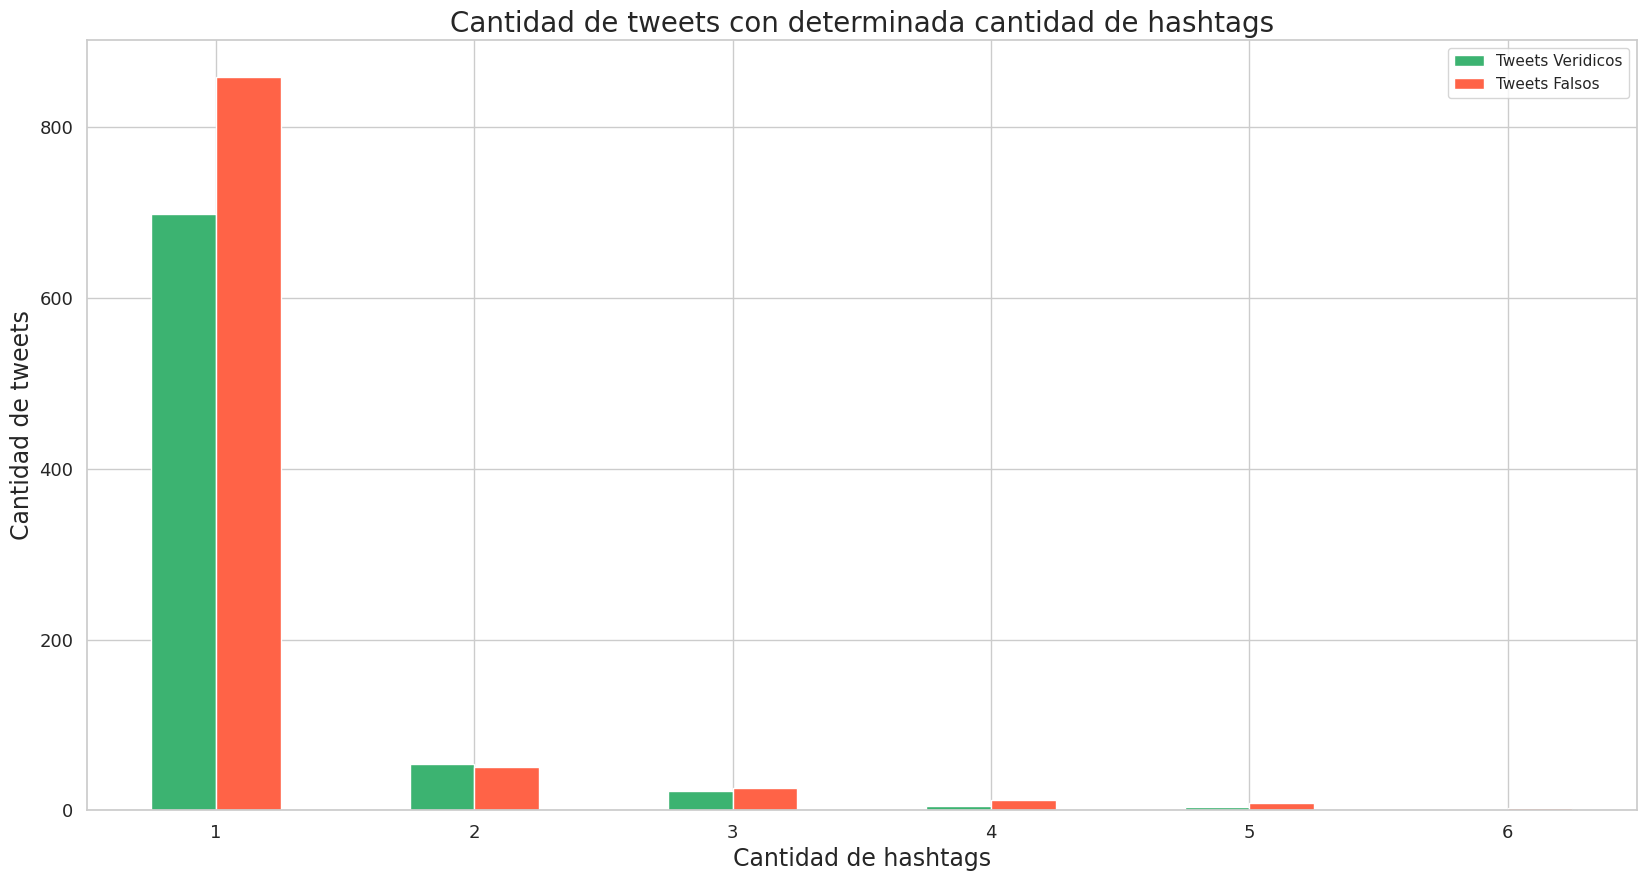

In [175]:
df= df_usa_patterns_real.groupby(['htg amount']).agg({'id':'sum'})\
.merge(df_usa_patterns_fake.groupby(['htg amount']).agg({'id':'sum'}), on = 'htg amount')
df = df.rename(columns={'id_x': 'Tweets Veridicos','id_y': 'Tweets Falsos' })
df.plot.bar(color=('mediumseagreen','tomato'))
plt.xlabel('Cantidad de hashtags', fontsize = 17)
plt.ylabel('Cantidad de tweets', fontsize = 17)
plt.title('Cantidad de tweets con determinada cantidad de hashtags', fontsize = 20)
plt.tick_params(axis='both', labelsize = 13)
plt.xticks(rotation = 0)
plt.show()


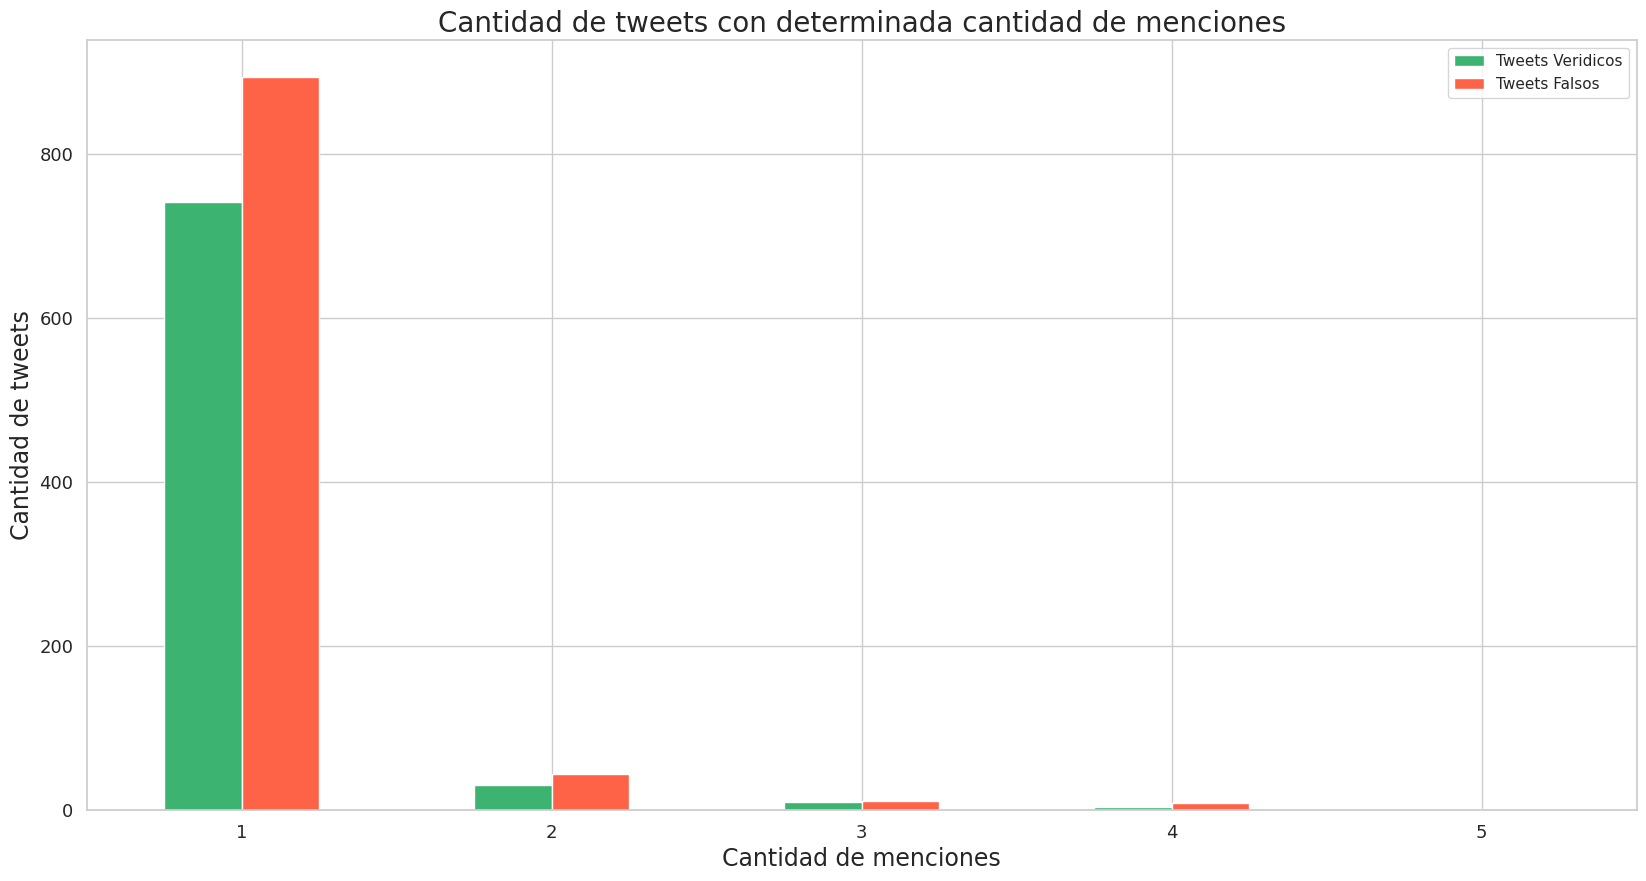

In [176]:
df = df_usa_patterns_real.groupby(['mentions amount']).agg({'id':'sum'})\
.merge(df_usa_patterns_fake.groupby(['mentions amount']).agg({'id':'sum'}), on = 'mentions amount')
df = df.rename(columns={'id_x': 'Tweets Veridicos','id_y': 'Tweets Falsos' })
df.plot.bar(color=('mediumseagreen','tomato'))
plt.xlabel('Cantidad de menciones', fontsize = 17)
plt.ylabel('Cantidad de tweets', fontsize = 17)
plt.title('Cantidad de tweets con determinada cantidad de menciones', fontsize = 20)
plt.tick_params(axis='both', labelsize = 13)
plt.xticks(rotation = 0)
plt.show()

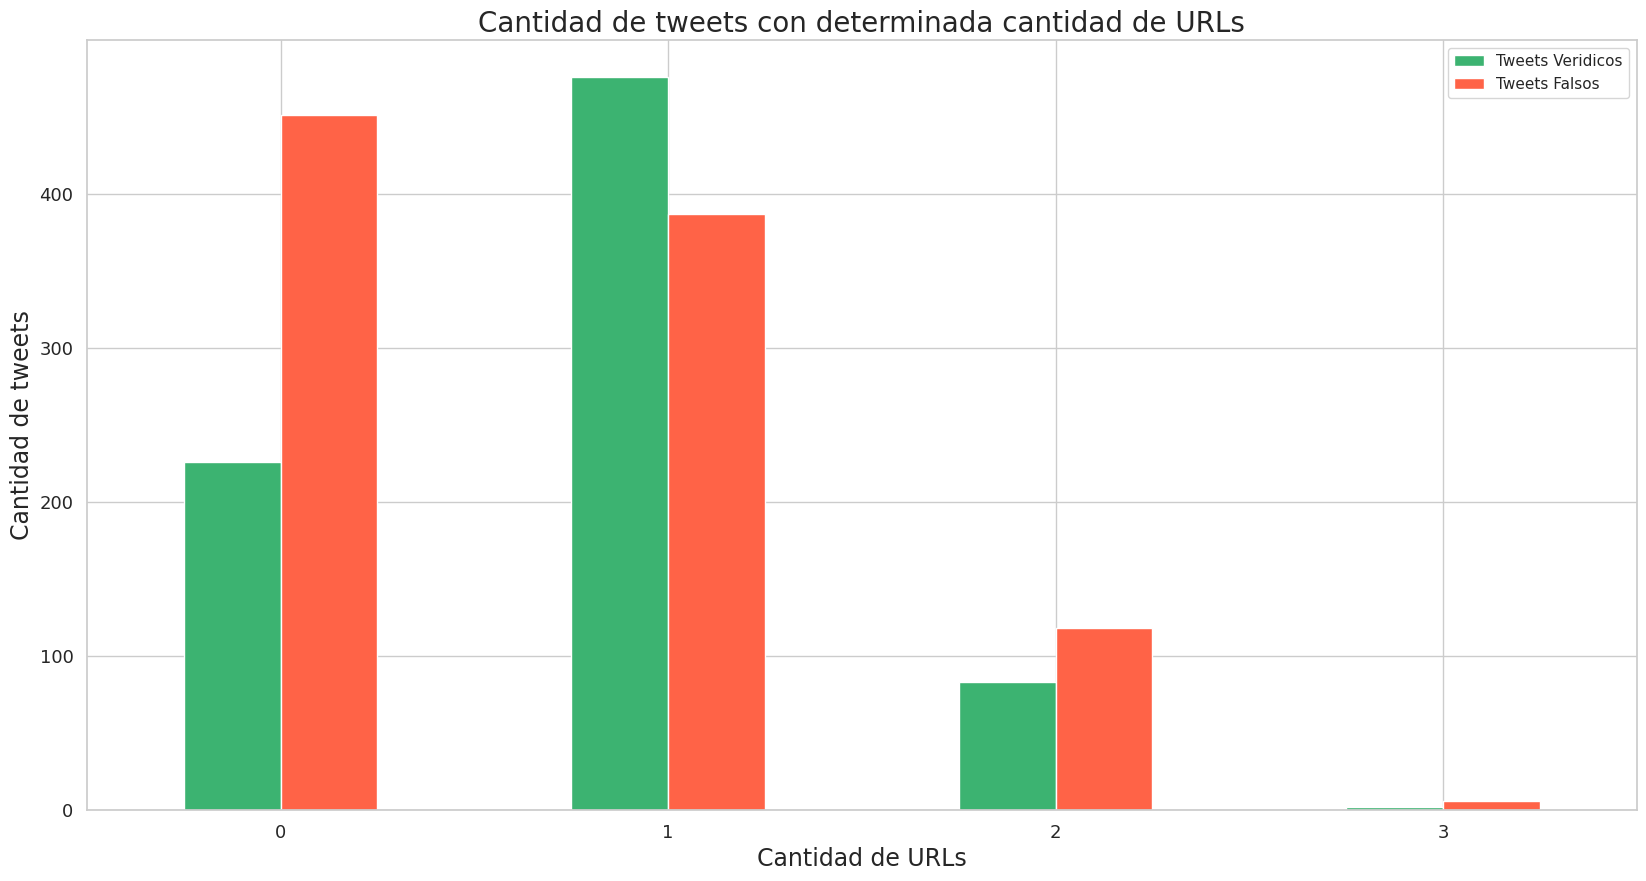

In [177]:
df = df_usa_patterns_real.groupby(['urls amount']).agg({'id':'sum'})\
.merge(df_usa_patterns_fake.groupby(['urls amount']).agg({'id':'sum'}), on = 'urls amount')
df = df.rename(columns={'id_x': 'Tweets Veridicos','id_y': 'Tweets Falsos' })
df.plot.bar(color=('mediumseagreen','tomato'))
plt.xlabel('Cantidad de URLs', fontsize = 17)
plt.ylabel('Cantidad de tweets', fontsize = 17)
plt.title('Cantidad de tweets con determinada cantidad de URLs', fontsize = 20)
plt.tick_params(axis='both', labelsize = 13)
plt.xticks(rotation = 0)
plt.show()